In [1]:
!pip install keras==2.3.0
!pip install tensorflow==2.2.0

  Using cached tensorflow-2.2.0-cp38-cp38-win_amd64.whl (459.2 MB)
  Using cached gast-0.3.3-py2.py3-none-any.whl (9.7 kB)
  Attempting uninstall: gast
    Found existing installation: gast 0.4.0
    Uninstalling gast-0.4.0:
      Successfully uninstalled gast-0.4.0
  Attempting uninstall: tensorflow
    Found existing installation: tensorflow 2.3.0
    Uninstalling tensorflow-2.3.0:
      Successfully uninstalled tensorflow-2.3.0


In [2]:
import pandas as pd
import numpy as np
import math
import random

from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.metrics import confusion_matrix
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Input, LSTM, Dense, Dropout, Embedding, Reshape, GRU, Bidirectional, RNN, SimpleRNN
from tensorflow.keras.callbacks import EarlyStopping

from pandas import read_csv
from datetime import datetime
from matplotlib import pyplot

from pandas import DataFrame
from pandas import concat
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MinMaxScaler

from math import sqrt
from numpy import concatenate
from sklearn.metrics import mean_squared_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM
from tensorflow.keras.utils import to_categorical
from sklearn import metrics

In [22]:
# name our columns
colnames = ['time', 'activityID', 'bpm'] + ['hand{}'.format(x) for x in range(13)] + ['chest{}'.format(x) for x in range(13)] + ['ankle{}'.format(x) for x in range(13)]

# exclude useless columns 
targetcols = set(range(0,54)).difference({16,17,18,19,33,34,35,36,50,51,52,53})

dataset = read_csv('PAMAP2_Dataset/Protocol/subject101.dat', sep=' ', names=colnames, usecols=targetcols)
    
dataset.loc[:,:] = dataset.loc[:,:].ffill()  #We forward fill all NaN values

In [23]:
dataset.columns

Index(['time', 'activityID', 'bpm', 'hand0', 'hand1', 'hand2', 'hand3',
       'hand4', 'hand5', 'hand6', 'hand7', 'hand8', 'hand9', 'hand10',
       'hand11', 'hand12', 'chest0', 'chest1', 'chest2', 'chest3', 'chest4',
       'chest5', 'chest6', 'chest7', 'chest8', 'chest9', 'chest10', 'chest11',
       'chest12', 'ankle0', 'ankle1', 'ankle2', 'ankle3', 'ankle4', 'ankle5',
       'ankle6', 'ankle7', 'ankle8', 'ankle9', 'ankle10', 'ankle11',
       'ankle12'],
      dtype='object')

In [24]:
pd.unique(dataset['activityID'])

array([ 0,  1,  2,  3, 17, 16, 12, 13,  4,  7,  6,  5, 24], dtype=int64)

In [25]:
targetcols = set(range(0,54)).difference({16,17,18,19,33,34,35,36,50,51,52,53})

dataset = read_csv('PAMAP2_Dataset/Protocol/subject101.dat', sep=' ', names=colnames, usecols=targetcols)

In [26]:
dataset.columns

Index(['time', 'activityID', 'bpm', 'hand0', 'hand1', 'hand2', 'hand3',
       'hand4', 'hand5', 'hand6', 'hand7', 'hand8', 'hand9', 'hand10',
       'hand11', 'hand12', 'chest0', 'chest1', 'chest2', 'chest3', 'chest4',
       'chest5', 'chest6', 'chest7', 'chest8', 'chest9', 'chest10', 'chest11',
       'chest12', 'ankle0', 'ankle1', 'ankle2', 'ankle3', 'ankle4', 'ankle5',
       'ankle6', 'ankle7', 'ankle8', 'ankle9', 'ankle10', 'ankle11',
       'ankle12'],
      dtype='object')

In [27]:
pd.unique(dataset['activityID'])

array([ 0,  1,  2,  3, 17, 16, 12, 13,  4,  7,  6,  5, 24], dtype=int64)

In [28]:
dataset.loc[:,:] = dataset.loc[:,:].ffill()  #We forward fill all NaN values

In [29]:
class_map = {
    0: 0,
    1: 1,
    2: 2,
    3: 3,
    4: 4,
    5: 5,
    6: 6,
    7: 7,
    12: 8,
    13: 9,
    16: 10,
    17: 11,
    24: 12
}

In [30]:
for ind in dataset.index:
     dataset['activityID'][ind] = class_map[dataset['activityID'][ind]]

<ipython-input-30-2d567c6e2ee2>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataset['activityID'][ind] = class_map[dataset['activityID'][ind]]


In [31]:
copy = dataset.copy()

In [32]:
# prepare data for lstm
# convert series to supervised learning
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
    n_vars = 1 if type(data) is list else data.shape[1]
    df = DataFrame(data)
    cols, names = list(), list()
    
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
    
    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
        else:
            names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
    
    # put it all together
    agg = concat(cols, axis=1)
    agg.columns = names
    
    # drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
    return agg

In [33]:
def preprocess(dataset):
    one_hot = pd.get_dummies(dataset['activityID'])
    dataset = dataset.drop('activityID',axis = 1)
    dataset = dataset.join(one_hot)    
    
    # load dataset
    values = dataset.values

    # ensure all data is float
    values = values.astype('float32')

    # normalize features
    scaler = MinMaxScaler(feature_range=(0, 1))
    scaled = scaler.fit_transform(values)

    # frame as supervised learning
    reframed = series_to_supervised(scaled, 1, 1)

    # drop columns we don't want to predict
    reframed.drop(reframed.columns[[*range(53, 104-11)]], axis=1, inplace=True)
    
    values = reframed.values
    n  = reframed.shape[0]
    n_train_hours = 365 * 24
    
    train = values[:-100000, :]
   # val = values[math.floor(n*.7):math.floor(n*.8), :]
    test = values[-150000:, :]
    val = test[:40000, :]
    test = test[40000:, :]

    # split into input and outputs
    train_X, train_y = train[:, :-12], train[:, -13:-1]
    val_X, val_y = val[:, :-12], val[:, -13:-1]
    test_X, test_y = test[:, :-12], test[:, -13:-1]


    # reshape input to be 3D [samples, timesteps, features]
    train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
    val_X = val_X.reshape((val_X.shape[0], 1, val_X.shape[1]))
    test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))

    #train_X, test_X = test_X, train_X
    #train_y, test_y = test_y, train_y

    return (train_X, train_y, val_X, val_y, test_X, test_y)

In [34]:
def notanumber(percent, dataset):
    n = dataset.shape[0]
    m = dataset.shape[1] - 2
    percent = percent * n * m
    lst = random.sample(range(0, n*m), math.floor(percent))
    #print(lst[1:5])
    for i in lst: 
        c = i / n
        r = i % n
        c = math.floor(c) + 2
        dataset.iloc[r,c] = np.nan
    return dataset

In [35]:
def noise(percent, sigma, dataset):
    n = dataset.shape[0]
    m = dataset.shape[1] - 2
    noise = np.random.normal(0,sigma,1)
    percent = percent * n * m
    lst = random.sample(range(0, n*m), math.floor(percent))
    for i in lst: 
        c = i / n
        r = i % n
        c = math.floor(c) + 2
        dataset.iloc[r,c] += noise
    return dataset

In [36]:
def drop(percent, dataset):
    n = dataset.shape[0]
    percent = percent * n
    lst = random.sample(range(0, n-1), math.floor(percent))
    #print(lst)
    rows = dataset.index[lst]
    dataset.drop(rows, inplace = True)
    return dataset

# LSTM

In [37]:
def lstm(train_X, train_y, val_X, val_y, test_X, test_y):
    # design network
    model = Sequential()
    model.add(LSTM(30, input_shape=(train_X.shape[1], train_X.shape[2])))
    model.add(Dense(12, activation='softmax'))
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['acc'])

    #es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=3)


    # fit network
    history = model.fit(train_X, train_y, epochs=10, batch_size=150, validation_data=(val_X, val_y), verbose=2, shuffle=False)
    
    
    testPredict = model.predict(test_X)
    #testPredict = scaler.inverse_transform(testPredict)
    #testY = scaler.inverse_transform([test_y])
    
    print(testPredict.shape)
    
    testScore = math.sqrt(mean_squared_error(test_y, testPredict)) #/test_y.shape[0]
    print('Test Score RMSE: ' + str(testScore))
    
    #gru_prediction = model.evaluate(test_X, test_y)
    #print("RNN GRU: " + str(gru_prediction) + "\n\n")
    
    #rnn_proba_gru = model.predict(test_X) #.squeeze()  # Prediction
    #rnn_auc_gru = metrics.roc_auc_score(test_y, rnn_proba_gru[:, 0])  # Calculate AUROC score
    #print("AUC: " + rnn_auc_gru)

    pyplot.plot(history.history['acc'])
    pyplot.plot(history.history['val_acc'])
    pyplot.title('model accuracy')
    pyplot.ylabel('accuracy')
    pyplot.xlabel('epoch')
    pyplot.legend(['train', 'validation'], loc='upper left')
    pyplot.show()

    # plot history
    pyplot.plot(history.history['loss'], label='train')
    pyplot.plot(history.history['val_loss'], label='test')
    pyplot.title('model loss')
    pyplot.ylabel('loss')
    pyplot.xlabel('epoch')
    pyplot.legend(['train', 'validation'], loc='upper left')
    pyplot.show()
    
    return testScore

# GRU

In [38]:
def gru(train_X, train_y, val_X, val_y, test_X, test_y):
    # design network
    model = Sequential()
    model.add(GRU(30, input_shape=(train_X.shape[1], train_X.shape[2])))
    model.add(Dense(12, activation='softmax'))
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['acc'])

    # fit network
    history = model.fit(train_X, train_y, epochs=10, batch_size=150, validation_data=(val_X, val_y), verbose=2, shuffle=False)

    
    testPredict = model.predict(test_X)
    #testPredict = scaler.inverse_transform(testPredict)
    #testY = scaler.inverse_transform([test_y])
    
    print(testPredict.shape)
    
    testScore = math.sqrt(mean_squared_error(test_y, testPredict)) #/test_y.shape[0]
    print('Test Score RMSE: ' + str(testScore))
    
    
    pyplot.plot(history.history['acc'])
    pyplot.plot(history.history['val_acc'])
    pyplot.title('model accuracy')
    pyplot.ylabel('accuracy')
    pyplot.xlabel('epoch')
    pyplot.legend(['train', 'validation'], loc='upper left')
    pyplot.show()

    # plot history
    pyplot.plot(history.history['loss'], label='train')
    pyplot.plot(history.history['val_loss'], label='test')
    pyplot.title('model loss')
    pyplot.ylabel('loss')
    pyplot.xlabel('epoch')
    pyplot.legend(['train', 'validation'], loc='upper left')
    pyplot.show()
    return testScore

# Simple RNN

In [39]:
def simpleRNN(train_X, train_y, val_X, val_y, test_X, test_y):
    # design network
    model = Sequential()
    model.add(SimpleRNN(30, input_shape=(train_X.shape[1], train_X.shape[2])))
    model.add(Dense(12, activation='softmax'))
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['acc'])

    # fit network
    history = model.fit(train_X, train_y, epochs=10, batch_size=150, validation_data=(val_X, val_y), verbose=2, shuffle=False)

    
    testPredict = model.predict(test_X)
    #testPredict = scaler.inverse_transform(testPredict)
    #testY = scaler.inverse_transform([test_y])
    
    print(testPredict.shape)
    
    testScore = math.sqrt(mean_squared_error(test_y, testPredict)) #/test_y.shape[0]
    print('Test Score RMSE: ' + str(testScore))
    
    
    pyplot.plot(history.history['acc'])
    pyplot.plot(history.history['val_acc'])
    pyplot.title('model accuracy')
    pyplot.ylabel('accuracy')
    pyplot.xlabel('epoch')
    pyplot.legend(['train', 'validation'], loc='upper left')
    pyplot.show()

    # plot history
    pyplot.plot(history.history['loss'], label='train')
    pyplot.plot(history.history['val_loss'], label='test')
    pyplot.title('model loss')
    pyplot.ylabel('loss')
    pyplot.xlabel('epoch')
    pyplot.legend(['train', 'validation'], loc='upper left')
    pyplot.show()
    return testScore

# EXPERIMENT 1:

(257596, 1, 56) (257596, 12) (40000, 1, 56) (40000, 12) (110000, 1, 56) (110000, 12)
Epoch 1/10
1718/1718 - 5s - loss: 0.9281 - acc: 0.7540 - val_loss: 2.9868 - val_acc: 0.1782
Epoch 2/10
1718/1718 - 4s - loss: 0.3203 - acc: 0.9062 - val_loss: 2.4474 - val_acc: 0.4714
Epoch 3/10
1718/1718 - 4s - loss: 0.1347 - acc: 0.9576 - val_loss: 2.1452 - val_acc: 0.4714
Epoch 4/10
1718/1718 - 5s - loss: 0.0439 - acc: 0.9857 - val_loss: 1.4754 - val_acc: 0.4713
Epoch 5/10
1718/1718 - 4s - loss: 0.0140 - acc: 0.9999 - val_loss: 0.2229 - val_acc: 0.9969
Epoch 6/10
1718/1718 - 4s - loss: 0.0047 - acc: 0.9999 - val_loss: 0.0160 - val_acc: 0.9999
Epoch 7/10
1718/1718 - 4s - loss: 0.0019 - acc: 0.9999 - val_loss: 0.0034 - val_acc: 0.9999
Epoch 8/10
1718/1718 - 4s - loss: 9.7256e-04 - acc: 0.9999 - val_loss: 0.0011 - val_acc: 0.9999
Epoch 9/10
1718/1718 - 4s - loss: 6.2560e-04 - acc: 0.9999 - val_loss: 5.2090e-04 - val_acc: 0.9999
Epoch 10/10
1718/1718 - 4s - loss: 4.7241e-04 - acc: 0.9999 - val_loss: 3.4

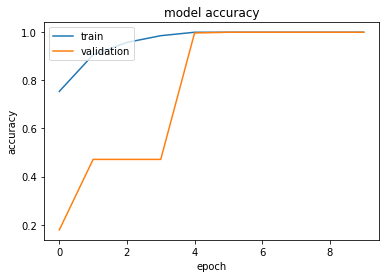

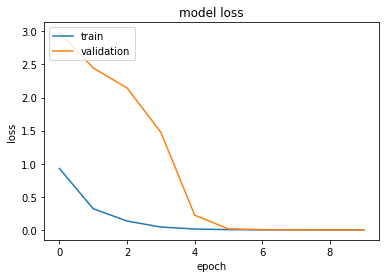

Epoch 1/10


KeyboardInterrupt: 

In [546]:
lst = range(5,40, 5)
test_acc_lstm = list()
#test_acc_lstm2 = list()
test_acc_gru = list()
test_acc_simple = list()

for i in lst:
    dataset = copy.copy()
    dataset = drop(i/100, dataset)
    train_X, train_y, val_X, val_y, test_X, test_y  = preprocess(dataset)
    print(train_X.shape, train_y.shape, val_X.shape, val_y.shape, test_X.shape, test_y.shape)
    
    accuracy_lstm = lstm(train_X, train_y, val_X, val_y, test_X, test_y)
    test_acc_lstm.append(accuracy_lstm)
    
    accuracy_gru = gru(train_X, train_y, val_X, val_y, test_X, test_y)
    test_acc_gru.append(accuracy_gru)
    
    accuracy_simple = simpleRNN(train_X, train_y, val_X, val_y, test_X, test_y)
    test_acc_simple.append(accuracy_simple)
    
pyplot.plot(lst,test_acc_lstm)
pyplot.plot(lst,test_acc_gru)
pyplot.plot(lst,test_acc_simple)
pyplot.title('RMSE at different levels of missing observation')
pyplot.ylabel('RMSE')
pyplot.xlabel('Percent of Observations Missing')
pyplot.legend(['LSTM', 'GRU', 'RNN'], loc='upper left')
pyplot.show()

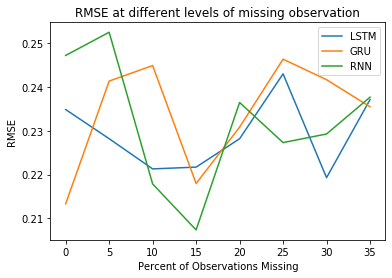

In [392]:
pyplot.plot(lst,test_acc_lstm)
pyplot.plot(lst,test_acc_gru)
pyplot.plot(lst,test_acc_simple)
pyplot.title('RMSE at different levels of missing observation')
pyplot.ylabel('RMSE')
pyplot.xlabel('Percent of Observations Missing')
pyplot.legend(['LSTM', 'GRU', 'RNN'], loc='best')
pyplot.show()

# Experiment 2

(276413, 1, 56) (276413, 12) (40000, 1, 56) (40000, 12) (110000, 1, 56) (110000, 12)
Epoch 1/10
1843/1843 - 3s - loss: 0.8687 - acc: 0.7689 - val_loss: 1.7780 - val_acc: 0.5101
Epoch 2/10
1843/1843 - 3s - loss: 0.2914 - acc: 0.9161 - val_loss: 2.4357 - val_acc: 0.5101
Epoch 3/10
1843/1843 - 3s - loss: 0.1186 - acc: 0.9627 - val_loss: 2.1200 - val_acc: 0.5101
Epoch 4/10
1843/1843 - 3s - loss: 0.0348 - acc: 0.9899 - val_loss: 1.3985 - val_acc: 0.5101
Epoch 5/10
1843/1843 - 3s - loss: 0.0093 - acc: 0.9999 - val_loss: 0.2045 - val_acc: 0.9999
Epoch 6/10
1843/1843 - 3s - loss: 0.0031 - acc: 0.9999 - val_loss: 0.0160 - val_acc: 0.9999
Epoch 7/10
1843/1843 - 3s - loss: 0.0013 - acc: 0.9999 - val_loss: 0.0036 - val_acc: 0.9999
Epoch 8/10
1843/1843 - 3s - loss: 7.1549e-04 - acc: 0.9999 - val_loss: 0.0011 - val_acc: 1.0000
Epoch 9/10
1843/1843 - 3s - loss: 5.0449e-04 - acc: 0.9999 - val_loss: 4.6961e-04 - val_acc: 1.0000
Epoch 10/10
1843/1843 - 3s - loss: 3.9151e-04 - acc: 0.9999 - val_loss: 3.0

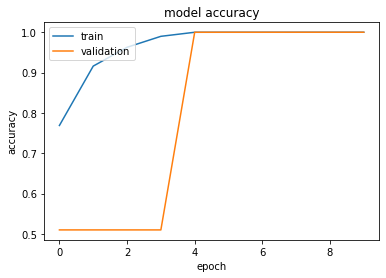

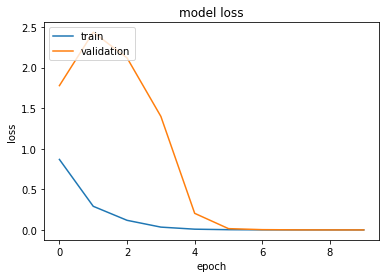

Epoch 1/10
1843/1843 - 3s - loss: 0.7724 - acc: 0.7920 - val_loss: 1.6254 - val_acc: 0.5101
Epoch 2/10
1843/1843 - 3s - loss: 0.2855 - acc: 0.9152 - val_loss: 2.2596 - val_acc: 0.5101
Epoch 3/10
1843/1843 - 3s - loss: 0.1244 - acc: 0.9612 - val_loss: 2.0949 - val_acc: 0.5101
Epoch 4/10
1843/1843 - 3s - loss: 0.0484 - acc: 0.9822 - val_loss: 1.7610 - val_acc: 0.5101
Epoch 5/10
1843/1843 - 3s - loss: 0.0155 - acc: 0.9978 - val_loss: 0.6654 - val_acc: 0.5101
Epoch 6/10
1843/1843 - 3s - loss: 0.0053 - acc: 0.9999 - val_loss: 0.0646 - val_acc: 0.9999
Epoch 7/10
1843/1843 - 3s - loss: 0.0020 - acc: 0.9999 - val_loss: 0.0083 - val_acc: 0.9999
Epoch 8/10
1843/1843 - 3s - loss: 9.1570e-04 - acc: 0.9999 - val_loss: 0.0015 - val_acc: 0.9999
Epoch 9/10
1843/1843 - 3s - loss: 5.4519e-04 - acc: 0.9999 - val_loss: 5.2335e-04 - val_acc: 1.0000
Epoch 10/10
1843/1843 - 3s - loss: 3.9564e-04 - acc: 0.9999 - val_loss: 3.9031e-04 - val_acc: 1.0000
(110000, 12)
Test Score RMSE: 0.2244274563689255


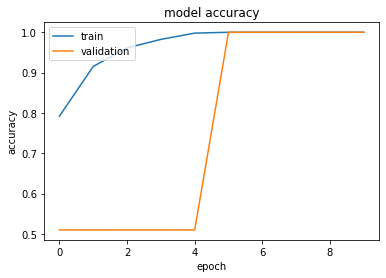

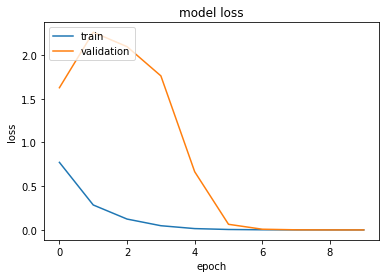

Epoch 1/10
1843/1843 - 2s - loss: 0.6741 - acc: 0.8248 - val_loss: 1.8733 - val_acc: 0.5101
Epoch 2/10
1843/1843 - 2s - loss: 0.2551 - acc: 0.9248 - val_loss: 2.6732 - val_acc: 0.5101
Epoch 3/10
1843/1843 - 2s - loss: 0.1285 - acc: 0.9578 - val_loss: 2.3362 - val_acc: 0.5101
Epoch 4/10
1843/1843 - 2s - loss: 0.0595 - acc: 0.9789 - val_loss: 1.7022 - val_acc: 0.5101
Epoch 5/10
1843/1843 - 2s - loss: 0.0248 - acc: 0.9944 - val_loss: 0.6995 - val_acc: 0.5101
Epoch 6/10
1843/1843 - 2s - loss: 0.0090 - acc: 0.9999 - val_loss: 0.0767 - val_acc: 0.9999
Epoch 7/10
1843/1843 - 2s - loss: 0.0034 - acc: 0.9999 - val_loss: 0.0096 - val_acc: 0.9999
Epoch 8/10
1843/1843 - 2s - loss: 0.0014 - acc: 0.9999 - val_loss: 0.0020 - val_acc: 0.9999
Epoch 9/10
1843/1843 - 2s - loss: 7.1946e-04 - acc: 0.9999 - val_loss: 5.8415e-04 - val_acc: 1.0000
Epoch 10/10
1843/1843 - 2s - loss: 4.5462e-04 - acc: 1.0000 - val_loss: 2.5919e-04 - val_acc: 1.0000
(110000, 12)
Test Score RMSE: 0.22743930185080688


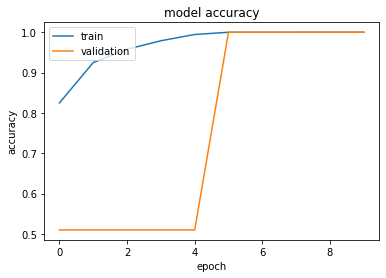

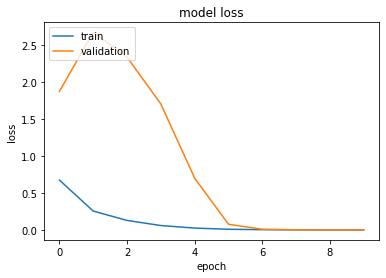

(276414, 1, 56) (276414, 12) (40000, 1, 56) (40000, 12) (110000, 1, 56) (110000, 12)
Epoch 1/10
1843/1843 - 4s - loss: 0.9277 - acc: 0.7565 - val_loss: 1.5293 - val_acc: 0.5101
Epoch 2/10
1843/1843 - 3s - loss: 0.2703 - acc: 0.9213 - val_loss: 2.1826 - val_acc: 0.5101
Epoch 3/10
1843/1843 - 3s - loss: 0.1185 - acc: 0.9650 - val_loss: 1.9937 - val_acc: 0.5101
Epoch 4/10
1843/1843 - 3s - loss: 0.0375 - acc: 0.9870 - val_loss: 1.2030 - val_acc: 0.5101
Epoch 5/10
1843/1843 - 3s - loss: 0.0105 - acc: 0.9998 - val_loss: 0.3606 - val_acc: 0.6901
Epoch 6/10
1843/1843 - 3s - loss: 0.0036 - acc: 0.9999 - val_loss: 0.0465 - val_acc: 0.9999
Epoch 7/10
1843/1843 - 3s - loss: 0.0015 - acc: 0.9999 - val_loss: 0.0047 - val_acc: 0.9999
Epoch 8/10
1843/1843 - 3s - loss: 7.6374e-04 - acc: 0.9999 - val_loss: 0.0011 - val_acc: 0.9999
Epoch 9/10
1843/1843 - 3s - loss: 5.0981e-04 - acc: 0.9999 - val_loss: 4.5951e-04 - val_acc: 1.0000
Epoch 10/10
1843/1843 - 3s - loss: 3.9451e-04 - acc: 0.9999 - val_loss: 2.8

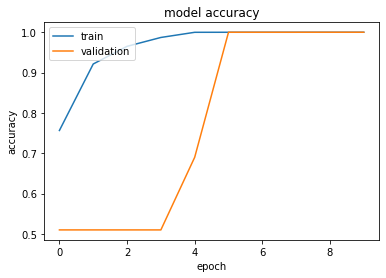

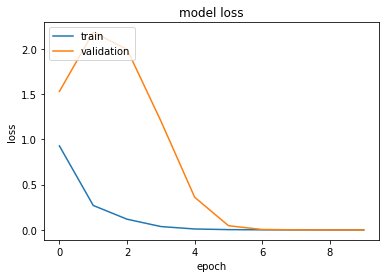

Epoch 1/10
1843/1843 - 4s - loss: 0.7500 - acc: 0.8061 - val_loss: 1.4953 - val_acc: 0.5101
Epoch 2/10
1843/1843 - 3s - loss: 0.2378 - acc: 0.9284 - val_loss: 1.9981 - val_acc: 0.5101
Epoch 3/10
1843/1843 - 3s - loss: 0.1175 - acc: 0.9606 - val_loss: 1.9348 - val_acc: 0.5101
Epoch 4/10
1843/1843 - 3s - loss: 0.0409 - acc: 0.9851 - val_loss: 1.2546 - val_acc: 0.5101
Epoch 5/10
1843/1843 - 3s - loss: 0.0129 - acc: 0.9991 - val_loss: 0.1821 - val_acc: 0.9999
Epoch 6/10
1843/1843 - 3s - loss: 0.0047 - acc: 0.9999 - val_loss: 0.0107 - val_acc: 0.9999
Epoch 7/10
1843/1843 - 3s - loss: 0.0021 - acc: 0.9999 - val_loss: 0.0019 - val_acc: 0.9999
Epoch 8/10
1843/1843 - 3s - loss: 0.0010 - acc: 0.9999 - val_loss: 5.8736e-04 - val_acc: 1.0000
Epoch 9/10
1843/1843 - 3s - loss: 6.0676e-04 - acc: 0.9999 - val_loss: 2.5201e-04 - val_acc: 1.0000
Epoch 10/10
1843/1843 - 3s - loss: 4.1885e-04 - acc: 0.9999 - val_loss: 1.2853e-04 - val_acc: 1.0000
(110000, 12)
Test Score RMSE: 0.22647381559549237


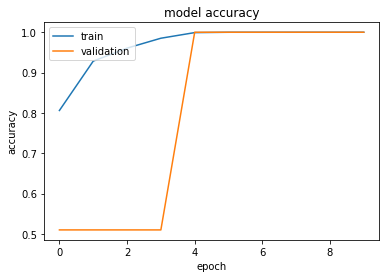

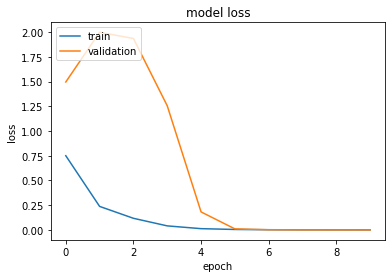

Epoch 1/10
1843/1843 - 2s - loss: 0.6437 - acc: 0.8379 - val_loss: 1.8958 - val_acc: 0.5101
Epoch 2/10
1843/1843 - 2s - loss: 0.2205 - acc: 0.9331 - val_loss: 2.3246 - val_acc: 0.5101
Epoch 3/10
1843/1843 - 2s - loss: 0.1046 - acc: 0.9642 - val_loss: 1.8093 - val_acc: 0.5101
Epoch 4/10
1843/1843 - 2s - loss: 0.0455 - acc: 0.9841 - val_loss: 1.1168 - val_acc: 0.5101
Epoch 5/10
1843/1843 - 2s - loss: 0.0171 - acc: 0.9991 - val_loss: 0.3815 - val_acc: 0.7007
Epoch 6/10
1843/1843 - 2s - loss: 0.0059 - acc: 0.9999 - val_loss: 0.0371 - val_acc: 0.9999
Epoch 7/10
1843/1843 - 2s - loss: 0.0023 - acc: 0.9999 - val_loss: 0.0047 - val_acc: 0.9999
Epoch 8/10
1843/1843 - 2s - loss: 0.0011 - acc: 0.9999 - val_loss: 0.0010 - val_acc: 0.9999
Epoch 9/10
1843/1843 - 2s - loss: 6.1502e-04 - acc: 0.9999 - val_loss: 3.9186e-04 - val_acc: 1.0000
Epoch 10/10
1843/1843 - 2s - loss: 4.4133e-04 - acc: 0.9999 - val_loss: 2.3244e-04 - val_acc: 1.0000
(110000, 12)
Test Score RMSE: 0.2385149653800792


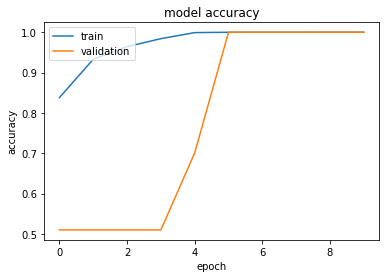

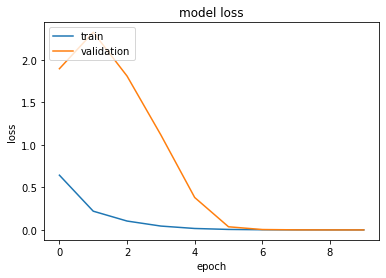

(276415, 1, 56) (276415, 12) (40000, 1, 56) (40000, 12) (110000, 1, 56) (110000, 12)
Epoch 1/10
1843/1843 - 4s - loss: 0.9398 - acc: 0.7526 - val_loss: 1.5299 - val_acc: 0.5101
Epoch 2/10
1843/1843 - 3s - loss: 0.2518 - acc: 0.9268 - val_loss: 1.9588 - val_acc: 0.5101
Epoch 3/10
1843/1843 - 3s - loss: 0.0938 - acc: 0.9700 - val_loss: 1.5996 - val_acc: 0.5101
Epoch 4/10
1843/1843 - 3s - loss: 0.0288 - acc: 0.9926 - val_loss: 0.8861 - val_acc: 0.5101
Epoch 5/10
1843/1843 - 3s - loss: 0.0082 - acc: 0.9999 - val_loss: 0.1013 - val_acc: 0.9999
Epoch 6/10
1843/1843 - 3s - loss: 0.0027 - acc: 0.9999 - val_loss: 0.0129 - val_acc: 0.9999
Epoch 7/10
1843/1843 - 3s - loss: 0.0012 - acc: 0.9999 - val_loss: 0.0029 - val_acc: 0.9999
Epoch 8/10
1843/1843 - 3s - loss: 6.6285e-04 - acc: 0.9999 - val_loss: 8.0300e-04 - val_acc: 1.0000
Epoch 9/10
1843/1843 - 3s - loss: 4.8033e-04 - acc: 0.9999 - val_loss: 3.5160e-04 - val_acc: 1.0000
Epoch 10/10
1843/1843 - 3s - loss: 3.8111e-04 - acc: 0.9999 - val_loss:

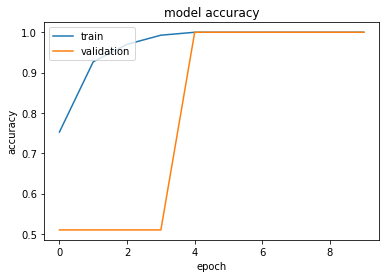

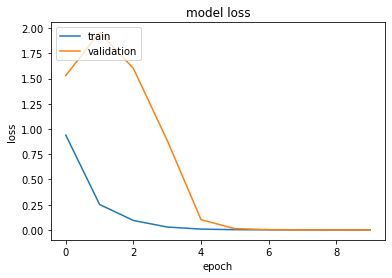

Epoch 1/10
1843/1843 - 4s - loss: 0.8034 - acc: 0.7913 - val_loss: 1.7025 - val_acc: 0.5101
Epoch 2/10
1843/1843 - 3s - loss: 0.2331 - acc: 0.9310 - val_loss: 2.5118 - val_acc: 0.5101
Epoch 3/10
1843/1843 - 3s - loss: 0.0956 - acc: 0.9693 - val_loss: 2.1124 - val_acc: 0.5101
Epoch 4/10
1843/1843 - 3s - loss: 0.0359 - acc: 0.9848 - val_loss: 1.3531 - val_acc: 0.5101
Epoch 5/10
1843/1843 - 3s - loss: 0.0120 - acc: 0.9993 - val_loss: 0.3430 - val_acc: 0.7627
Epoch 6/10
1843/1843 - 3s - loss: 0.0040 - acc: 0.9999 - val_loss: 0.0224 - val_acc: 0.9999
Epoch 7/10
1843/1843 - 3s - loss: 0.0015 - acc: 0.9999 - val_loss: 0.0026 - val_acc: 0.9999
Epoch 8/10
1843/1843 - 3s - loss: 7.2998e-04 - acc: 0.9999 - val_loss: 7.1441e-04 - val_acc: 0.9999
Epoch 9/10
1843/1843 - 3s - loss: 4.7721e-04 - acc: 0.9999 - val_loss: 2.9887e-04 - val_acc: 1.0000
Epoch 10/10
1843/1843 - 3s - loss: 3.6731e-04 - acc: 0.9999 - val_loss: 2.5519e-04 - val_acc: 1.0000
(110000, 12)
Test Score RMSE: 0.22976382797353034


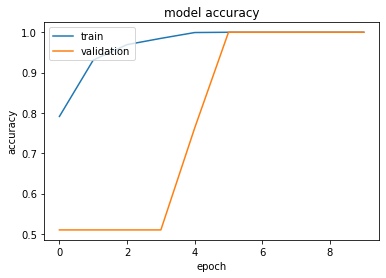

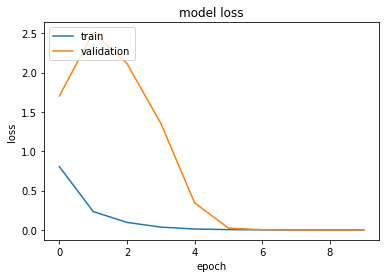

Epoch 1/10
1843/1843 - 2s - loss: 0.6961 - acc: 0.8228 - val_loss: 1.8510 - val_acc: 0.5101
Epoch 2/10
1843/1843 - 2s - loss: 0.2381 - acc: 0.9281 - val_loss: 2.1369 - val_acc: 0.5101
Epoch 3/10
1843/1843 - 2s - loss: 0.1114 - acc: 0.9644 - val_loss: 1.7449 - val_acc: 0.5101
Epoch 4/10
1843/1843 - 2s - loss: 0.0480 - acc: 0.9825 - val_loss: 1.0293 - val_acc: 0.5101
Epoch 5/10
1843/1843 - 2s - loss: 0.0198 - acc: 0.9959 - val_loss: 0.1537 - val_acc: 0.9999
Epoch 6/10
1843/1843 - 2s - loss: 0.0076 - acc: 0.9999 - val_loss: 0.0110 - val_acc: 0.9999
Epoch 7/10
1843/1843 - 2s - loss: 0.0029 - acc: 0.9999 - val_loss: 0.0019 - val_acc: 0.9999
Epoch 8/10
1843/1843 - 2s - loss: 0.0013 - acc: 0.9999 - val_loss: 5.5822e-04 - val_acc: 0.9999
Epoch 9/10
1843/1843 - 2s - loss: 6.8244e-04 - acc: 0.9999 - val_loss: 2.5175e-04 - val_acc: 1.0000
Epoch 10/10
1843/1843 - 2s - loss: 4.7292e-04 - acc: 0.9999 - val_loss: 1.5807e-04 - val_acc: 1.0000
(110000, 12)
Test Score RMSE: 0.21453572647136468


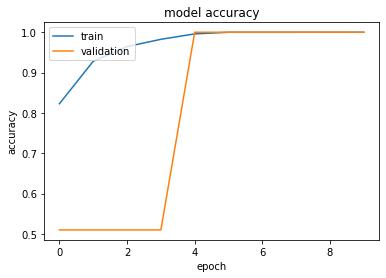

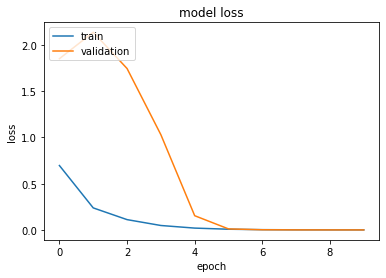

(276415, 1, 56) (276415, 12) (40000, 1, 56) (40000, 12) (110000, 1, 56) (110000, 12)
Epoch 1/10
1843/1843 - 4s - loss: 0.8436 - acc: 0.7789 - val_loss: 1.6209 - val_acc: 0.5101
Epoch 2/10
1843/1843 - 3s - loss: 0.2469 - acc: 0.9254 - val_loss: 2.1079 - val_acc: 0.5101
Epoch 3/10
1843/1843 - 3s - loss: 0.1191 - acc: 0.9639 - val_loss: 2.0371 - val_acc: 0.5101
Epoch 4/10
1843/1843 - 3s - loss: 0.0344 - acc: 0.9885 - val_loss: 0.9886 - val_acc: 0.5101
Epoch 5/10
1843/1843 - 3s - loss: 0.0107 - acc: 0.9996 - val_loss: 0.0692 - val_acc: 0.9999
Epoch 6/10
1843/1843 - 3s - loss: 0.0036 - acc: 0.9999 - val_loss: 0.0084 - val_acc: 0.9999
Epoch 7/10
1843/1843 - 3s - loss: 0.0014 - acc: 0.9999 - val_loss: 0.0016 - val_acc: 1.0000
Epoch 8/10
1843/1843 - 3s - loss: 7.2961e-04 - acc: 1.0000 - val_loss: 5.2824e-04 - val_acc: 1.0000
Epoch 9/10
1843/1843 - 3s - loss: 4.9944e-04 - acc: 0.9999 - val_loss: 2.4971e-04 - val_acc: 1.0000
Epoch 10/10
1843/1843 - 3s - loss: 3.8067e-04 - acc: 0.9999 - val_loss:

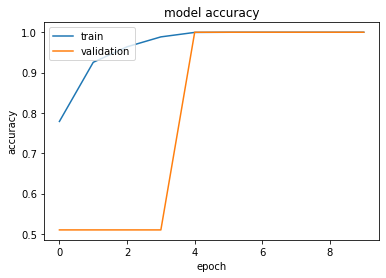

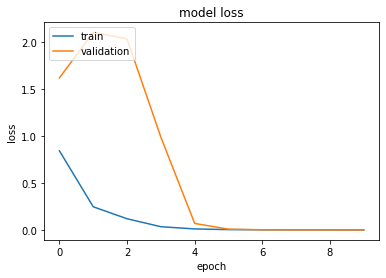

Epoch 1/10
1843/1843 - 4s - loss: 0.7784 - acc: 0.7978 - val_loss: 1.3744 - val_acc: 0.5101
Epoch 2/10
1843/1843 - 3s - loss: 0.2613 - acc: 0.9219 - val_loss: 2.0712 - val_acc: 0.5101
Epoch 3/10
1843/1843 - 4s - loss: 0.1125 - acc: 0.9618 - val_loss: 1.8168 - val_acc: 0.5101
Epoch 4/10
1843/1843 - 3s - loss: 0.0385 - acc: 0.9864 - val_loss: 1.1290 - val_acc: 0.5101
Epoch 5/10
1843/1843 - 3s - loss: 0.0114 - acc: 0.9999 - val_loss: 0.2447 - val_acc: 0.9942
Epoch 6/10
1843/1843 - 3s - loss: 0.0036 - acc: 0.9999 - val_loss: 0.0216 - val_acc: 0.9999
Epoch 7/10
1843/1843 - 3s - loss: 0.0014 - acc: 0.9999 - val_loss: 0.0032 - val_acc: 0.9999
Epoch 8/10
1843/1843 - 3s - loss: 7.2671e-04 - acc: 0.9999 - val_loss: 7.8144e-04 - val_acc: 0.9999
Epoch 9/10
1843/1843 - 3s - loss: 4.7305e-04 - acc: 0.9999 - val_loss: 3.1917e-04 - val_acc: 1.0000
Epoch 10/10
1843/1843 - 3s - loss: 3.5291e-04 - acc: 0.9999 - val_loss: 2.4534e-04 - val_acc: 1.0000
(110000, 12)
Test Score RMSE: 0.23630368287608236


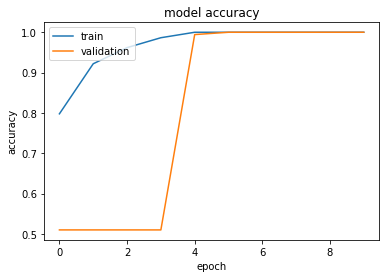

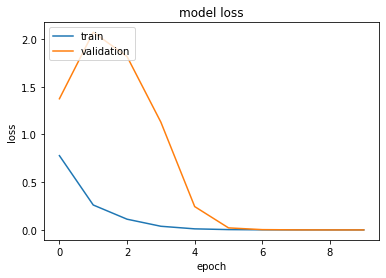

Epoch 1/10
1843/1843 - 2s - loss: 0.6369 - acc: 0.8359 - val_loss: 1.6901 - val_acc: 0.5101
Epoch 2/10
1843/1843 - 2s - loss: 0.2295 - acc: 0.9318 - val_loss: 2.3068 - val_acc: 0.5101
Epoch 3/10
1843/1843 - 2s - loss: 0.1158 - acc: 0.9626 - val_loss: 2.0169 - val_acc: 0.5101
Epoch 4/10
1843/1843 - 2s - loss: 0.0533 - acc: 0.9800 - val_loss: 1.5448 - val_acc: 0.5101
Epoch 5/10
1843/1843 - 2s - loss: 0.0220 - acc: 0.9957 - val_loss: 0.8981 - val_acc: 0.5101
Epoch 6/10
1843/1843 - 2s - loss: 0.0090 - acc: 0.9999 - val_loss: 0.2344 - val_acc: 0.9972
Epoch 7/10
1843/1843 - 2s - loss: 0.0036 - acc: 0.9999 - val_loss: 0.0325 - val_acc: 0.9999
Epoch 8/10
1843/1843 - 2s - loss: 0.0015 - acc: 0.9999 - val_loss: 0.0035 - val_acc: 0.9999
Epoch 9/10
1843/1843 - 2s - loss: 7.5492e-04 - acc: 0.9999 - val_loss: 9.5606e-04 - val_acc: 1.0000
Epoch 10/10
1843/1843 - 2s - loss: 4.6439e-04 - acc: 1.0000 - val_loss: 4.1979e-04 - val_acc: 1.0000
(110000, 12)
Test Score RMSE: 0.2389625050344944


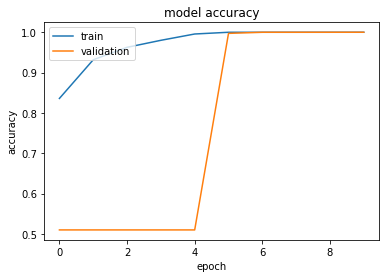

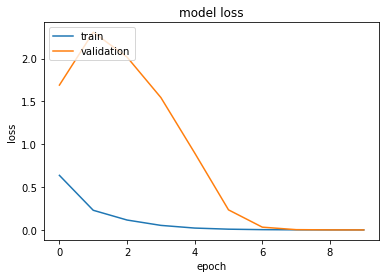

(276414, 1, 56) (276414, 12) (40000, 1, 56) (40000, 12) (110000, 1, 56) (110000, 12)
Epoch 1/10
1843/1843 - 3s - loss: 0.9159 - acc: 0.7613 - val_loss: 1.8406 - val_acc: 0.5101
Epoch 2/10
1843/1843 - 3s - loss: 0.2521 - acc: 0.9253 - val_loss: 1.9711 - val_acc: 0.5101
Epoch 3/10
1843/1843 - 3s - loss: 0.1047 - acc: 0.9672 - val_loss: 1.5494 - val_acc: 0.5101
Epoch 4/10
1843/1843 - 3s - loss: 0.0307 - acc: 0.9912 - val_loss: 0.2398 - val_acc: 0.9868
Epoch 5/10
1843/1843 - 3s - loss: 0.0091 - acc: 0.9999 - val_loss: 0.0165 - val_acc: 0.9999
Epoch 6/10
1843/1843 - 3s - loss: 0.0031 - acc: 0.9999 - val_loss: 0.0032 - val_acc: 0.9999
Epoch 7/10
1843/1843 - 3s - loss: 0.0013 - acc: 0.9999 - val_loss: 9.2700e-04 - val_acc: 1.0000
Epoch 8/10
1843/1843 - 3s - loss: 7.1110e-04 - acc: 0.9999 - val_loss: 3.9369e-04 - val_acc: 1.0000
Epoch 9/10
1843/1843 - 3s - loss: 4.9477e-04 - acc: 0.9999 - val_loss: 2.4199e-04 - val_acc: 1.0000
Epoch 10/10
1843/1843 - 3s - loss: 3.7130e-04 - acc: 0.9999 - val_l

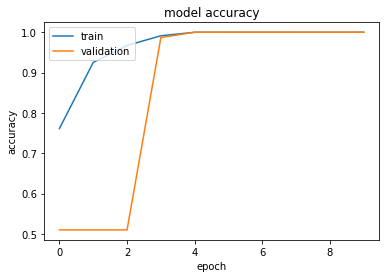

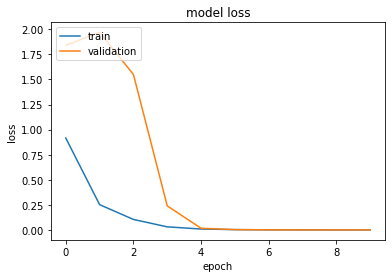

Epoch 1/10
1843/1843 - 3s - loss: 0.8299 - acc: 0.7830 - val_loss: 1.7215 - val_acc: 0.5101
Epoch 2/10
1843/1843 - 3s - loss: 0.2630 - acc: 0.9249 - val_loss: 2.2231 - val_acc: 0.5101
Epoch 3/10
1843/1843 - 3s - loss: 0.1138 - acc: 0.9622 - val_loss: 1.7930 - val_acc: 0.5101
Epoch 4/10
1843/1843 - 3s - loss: 0.0404 - acc: 0.9852 - val_loss: 1.4881 - val_acc: 0.5101
Epoch 5/10
1843/1843 - 3s - loss: 0.0131 - acc: 0.9996 - val_loss: 0.7365 - val_acc: 0.5101
Epoch 6/10
1843/1843 - 3s - loss: 0.0048 - acc: 0.9999 - val_loss: 0.0697 - val_acc: 0.9999
Epoch 7/10
1843/1843 - 3s - loss: 0.0019 - acc: 0.9999 - val_loss: 0.0085 - val_acc: 0.9999
Epoch 8/10
1843/1843 - 3s - loss: 8.9002e-04 - acc: 0.9999 - val_loss: 0.0015 - val_acc: 1.0000
Epoch 9/10
1843/1843 - 3s - loss: 5.4709e-04 - acc: 0.9999 - val_loss: 4.2123e-04 - val_acc: 1.0000
Epoch 10/10
1843/1843 - 3s - loss: 4.0188e-04 - acc: 0.9999 - val_loss: 2.2629e-04 - val_acc: 1.0000
(110000, 12)
Test Score RMSE: 0.21662459530492667


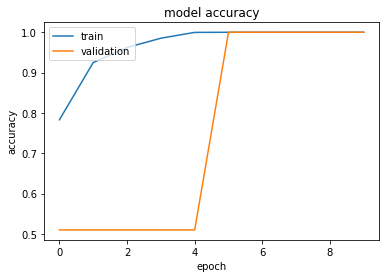

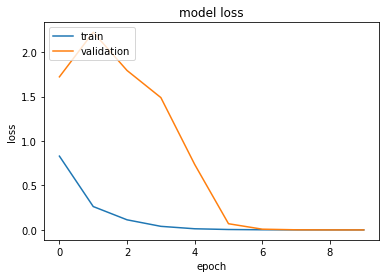

Epoch 1/10
1843/1843 - 2s - loss: 0.6622 - acc: 0.8259 - val_loss: 1.9511 - val_acc: 0.5101
Epoch 2/10
1843/1843 - 2s - loss: 0.2305 - acc: 0.9277 - val_loss: 2.6432 - val_acc: 0.5101
Epoch 3/10
1843/1843 - 2s - loss: 0.1108 - acc: 0.9626 - val_loss: 2.2433 - val_acc: 0.5101
Epoch 4/10
1843/1843 - 2s - loss: 0.0518 - acc: 0.9808 - val_loss: 1.7675 - val_acc: 0.5101
Epoch 5/10
1843/1843 - 2s - loss: 0.0207 - acc: 0.9961 - val_loss: 1.0075 - val_acc: 0.5101
Epoch 6/10
1843/1843 - 2s - loss: 0.0076 - acc: 0.9999 - val_loss: 0.1483 - val_acc: 0.9999
Epoch 7/10
1843/1843 - 2s - loss: 0.0031 - acc: 0.9999 - val_loss: 0.0217 - val_acc: 0.9999
Epoch 8/10
1843/1843 - 2s - loss: 0.0013 - acc: 0.9999 - val_loss: 0.0037 - val_acc: 0.9999
Epoch 9/10
1843/1843 - 2s - loss: 6.9885e-04 - acc: 0.9999 - val_loss: 9.4480e-04 - val_acc: 1.0000
Epoch 10/10
1843/1843 - 2s - loss: 4.6130e-04 - acc: 0.9999 - val_loss: 4.2320e-04 - val_acc: 1.0000
(110000, 12)
Test Score RMSE: 0.23024981007842557


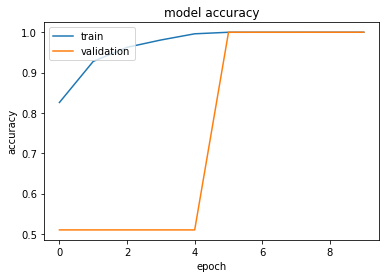

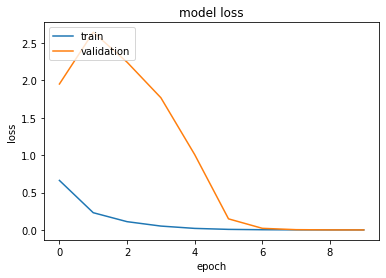

(276413, 1, 56) (276413, 12) (40000, 1, 56) (40000, 12) (110000, 1, 56) (110000, 12)
Epoch 1/10
1843/1843 - 3s - loss: 0.9009 - acc: 0.7718 - val_loss: 1.7520 - val_acc: 0.5101
Epoch 2/10
1843/1843 - 3s - loss: 0.2845 - acc: 0.9194 - val_loss: 2.1654 - val_acc: 0.5101
Epoch 3/10
1843/1843 - 3s - loss: 0.1170 - acc: 0.9619 - val_loss: 1.8998 - val_acc: 0.5101
Epoch 4/10
1843/1843 - 3s - loss: 0.0341 - acc: 0.9893 - val_loss: 1.3982 - val_acc: 0.5101
Epoch 5/10
1843/1843 - 3s - loss: 0.0096 - acc: 0.9999 - val_loss: 0.2845 - val_acc: 0.9549
Epoch 6/10
1843/1843 - 3s - loss: 0.0032 - acc: 0.9999 - val_loss: 0.0173 - val_acc: 1.0000
Epoch 7/10
1843/1843 - 3s - loss: 0.0013 - acc: 0.9999 - val_loss: 0.0038 - val_acc: 1.0000
Epoch 8/10
1843/1843 - 3s - loss: 7.1215e-04 - acc: 0.9999 - val_loss: 0.0012 - val_acc: 1.0000
Epoch 9/10
1843/1843 - 3s - loss: 4.8801e-04 - acc: 0.9999 - val_loss: 4.0603e-04 - val_acc: 1.0000
Epoch 10/10
1843/1843 - 3s - loss: 3.6999e-04 - acc: 0.9999 - val_loss: 2.5

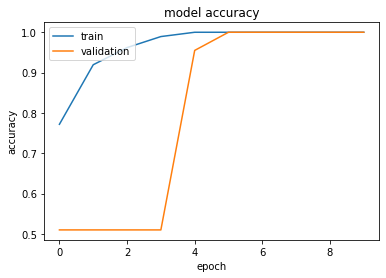

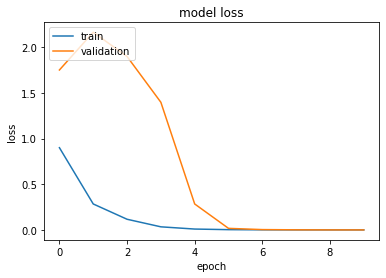

Epoch 1/10
1843/1843 - 3s - loss: 0.7798 - acc: 0.7932 - val_loss: 1.7494 - val_acc: 0.5101
Epoch 2/10
1843/1843 - 3s - loss: 0.2533 - acc: 0.9235 - val_loss: 2.4448 - val_acc: 0.5101
Epoch 3/10
1843/1843 - 3s - loss: 0.1102 - acc: 0.9639 - val_loss: 2.3813 - val_acc: 0.5101
Epoch 4/10
1843/1843 - 3s - loss: 0.0435 - acc: 0.9838 - val_loss: 1.8692 - val_acc: 0.5101
Epoch 5/10
1843/1843 - 3s - loss: 0.0153 - acc: 0.9987 - val_loss: 1.2663 - val_acc: 0.5101
Epoch 6/10
1843/1843 - 3s - loss: 0.0056 - acc: 0.9999 - val_loss: 0.3608 - val_acc: 0.6797
Epoch 7/10
1843/1843 - 3s - loss: 0.0021 - acc: 0.9999 - val_loss: 0.0157 - val_acc: 0.9999
Epoch 8/10
1843/1843 - 3s - loss: 9.5830e-04 - acc: 0.9999 - val_loss: 0.0019 - val_acc: 0.9999
Epoch 9/10
1843/1843 - 3s - loss: 5.6970e-04 - acc: 0.9999 - val_loss: 4.7624e-04 - val_acc: 1.0000
Epoch 10/10
1843/1843 - 3s - loss: 4.1149e-04 - acc: 0.9999 - val_loss: 2.0434e-04 - val_acc: 1.0000
(110000, 12)
Test Score RMSE: 0.22860565205407266


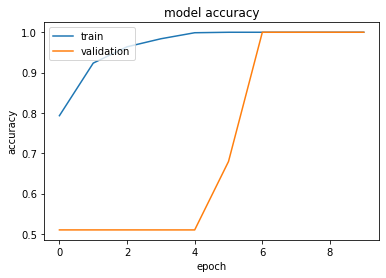

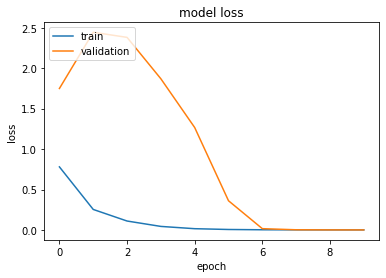

Epoch 1/10
1843/1843 - 2s - loss: 0.6451 - acc: 0.8315 - val_loss: 1.3286 - val_acc: 0.5101
Epoch 2/10
1843/1843 - 2s - loss: 0.2266 - acc: 0.9333 - val_loss: 2.3394 - val_acc: 0.5101
Epoch 3/10
1843/1843 - 2s - loss: 0.1164 - acc: 0.9614 - val_loss: 1.9386 - val_acc: 0.5101
Epoch 4/10
1843/1843 - 2s - loss: 0.0500 - acc: 0.9812 - val_loss: 1.3694 - val_acc: 0.5101
Epoch 5/10
1843/1843 - 2s - loss: 0.0199 - acc: 0.9975 - val_loss: 0.5665 - val_acc: 0.5107
Epoch 6/10
1843/1843 - 2s - loss: 0.0080 - acc: 0.9999 - val_loss: 0.0681 - val_acc: 0.9999
Epoch 7/10
1843/1843 - 2s - loss: 0.0032 - acc: 0.9999 - val_loss: 0.0099 - val_acc: 0.9999
Epoch 8/10
1843/1843 - 2s - loss: 0.0014 - acc: 0.9999 - val_loss: 0.0021 - val_acc: 0.9999
Epoch 9/10
1843/1843 - 2s - loss: 7.1450e-04 - acc: 0.9999 - val_loss: 7.6049e-04 - val_acc: 0.9999
Epoch 10/10
1843/1843 - 2s - loss: 4.6750e-04 - acc: 0.9999 - val_loss: 4.2421e-04 - val_acc: 1.0000
(110000, 12)
Test Score RMSE: 0.2401723083706607


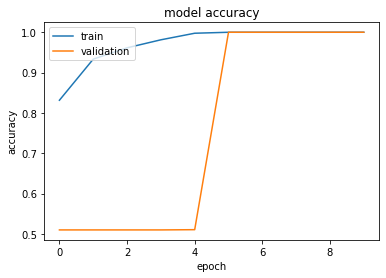

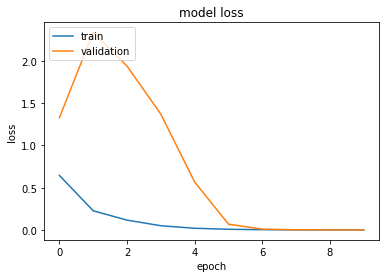

(276410, 1, 56) (276410, 12) (40000, 1, 56) (40000, 12) (110000, 1, 56) (110000, 12)
Epoch 1/10
1843/1843 - 3s - loss: 0.8607 - acc: 0.7684 - val_loss: 1.6644 - val_acc: 0.5101
Epoch 2/10
1843/1843 - 3s - loss: 0.2783 - acc: 0.9191 - val_loss: 2.3396 - val_acc: 0.5101
Epoch 3/10
1843/1843 - 3s - loss: 0.1091 - acc: 0.9671 - val_loss: 2.1054 - val_acc: 0.5101
Epoch 4/10
1843/1843 - 3s - loss: 0.0369 - acc: 0.9867 - val_loss: 1.8955 - val_acc: 0.5101
Epoch 5/10
1843/1843 - 3s - loss: 0.0123 - acc: 0.9987 - val_loss: 1.3038 - val_acc: 0.5101
Epoch 6/10
1843/1843 - 3s - loss: 0.0042 - acc: 0.9999 - val_loss: 0.1725 - val_acc: 0.9999
Epoch 7/10
1843/1843 - 3s - loss: 0.0016 - acc: 0.9999 - val_loss: 0.0120 - val_acc: 0.9999
Epoch 8/10
1843/1843 - 3s - loss: 7.8415e-04 - acc: 1.0000 - val_loss: 0.0023 - val_acc: 1.0000
Epoch 9/10
1843/1843 - 3s - loss: 4.8449e-04 - acc: 1.0000 - val_loss: 7.6254e-04 - val_acc: 1.0000
Epoch 10/10
1843/1843 - 3s - loss: 3.6051e-04 - acc: 1.0000 - val_loss: 4.0

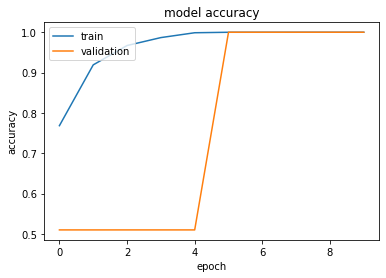

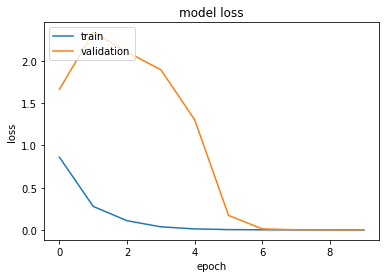

Epoch 1/10
1843/1843 - 3s - loss: 0.8009 - acc: 0.7902 - val_loss: 2.0494 - val_acc: 0.5101
Epoch 2/10
1843/1843 - 3s - loss: 0.2562 - acc: 0.9251 - val_loss: 2.4641 - val_acc: 0.5101
Epoch 3/10
1843/1843 - 3s - loss: 0.1063 - acc: 0.9649 - val_loss: 2.1553 - val_acc: 0.5101
Epoch 4/10
1843/1843 - 3s - loss: 0.0320 - acc: 0.9894 - val_loss: 1.1426 - val_acc: 0.5101
Epoch 5/10
1843/1843 - 3s - loss: 0.0091 - acc: 0.9999 - val_loss: 0.0690 - val_acc: 0.9999
Epoch 6/10
1843/1843 - 3s - loss: 0.0030 - acc: 0.9999 - val_loss: 0.0080 - val_acc: 0.9999
Epoch 7/10
1843/1843 - 3s - loss: 0.0012 - acc: 0.9999 - val_loss: 0.0018 - val_acc: 0.9999
Epoch 8/10
1843/1843 - 3s - loss: 6.7719e-04 - acc: 0.9999 - val_loss: 5.5499e-04 - val_acc: 1.0000
Epoch 9/10
1843/1843 - 3s - loss: 4.8620e-04 - acc: 0.9999 - val_loss: 3.3849e-04 - val_acc: 1.0000
Epoch 10/10
1843/1843 - 3s - loss: 3.8582e-04 - acc: 0.9999 - val_loss: 3.4645e-04 - val_acc: 1.0000
(110000, 12)
Test Score RMSE: 0.2550932939584458


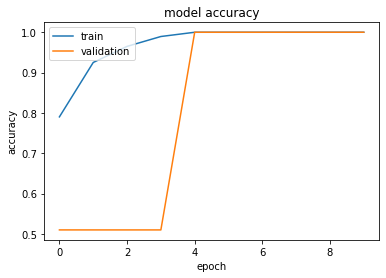

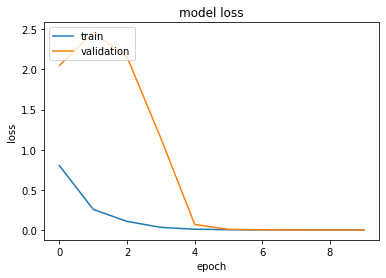

Epoch 1/10
1843/1843 - 2s - loss: 0.6491 - acc: 0.8276 - val_loss: 1.6948 - val_acc: 0.5101
Epoch 2/10
1843/1843 - 2s - loss: 0.2202 - acc: 0.9324 - val_loss: 2.7042 - val_acc: 0.5101
Epoch 3/10
1843/1843 - 2s - loss: 0.1051 - acc: 0.9652 - val_loss: 2.4662 - val_acc: 0.5101
Epoch 4/10
1843/1843 - 2s - loss: 0.0489 - acc: 0.9817 - val_loss: 1.6699 - val_acc: 0.5101
Epoch 5/10
1843/1843 - 2s - loss: 0.0184 - acc: 0.9986 - val_loss: 0.5689 - val_acc: 0.5166
Epoch 6/10
1843/1843 - 2s - loss: 0.0068 - acc: 0.9999 - val_loss: 0.0412 - val_acc: 0.9999
Epoch 7/10
1843/1843 - 2s - loss: 0.0026 - acc: 0.9999 - val_loss: 0.0061 - val_acc: 0.9999
Epoch 8/10
1843/1843 - 2s - loss: 0.0011 - acc: 0.9999 - val_loss: 0.0015 - val_acc: 0.9999
Epoch 9/10
1843/1843 - 2s - loss: 6.3005e-04 - acc: 0.9999 - val_loss: 4.8081e-04 - val_acc: 1.0000
Epoch 10/10
1843/1843 - 2s - loss: 4.3488e-04 - acc: 0.9999 - val_loss: 2.2344e-04 - val_acc: 1.0000
(110000, 12)
Test Score RMSE: 0.2499146092137671


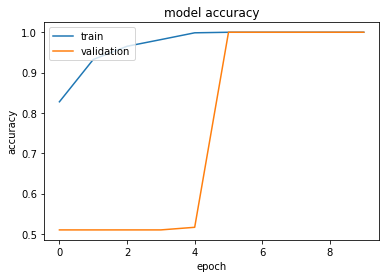

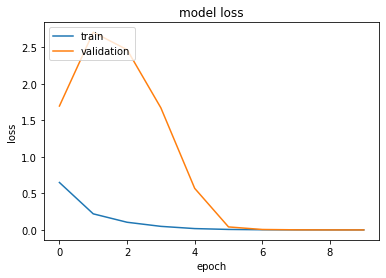

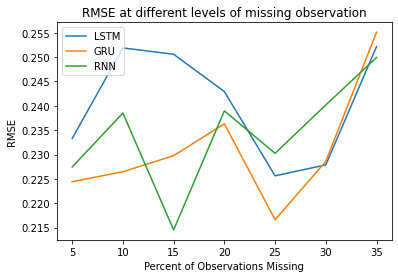

In [21]:
lst = range(5,40, 5)
test_acc_lstm = list()
test_acc_gru = list()
test_acc_simple = list()

for i in lst:
    dataset = copy.copy()
    dataset = notanumber(i/100, dataset)
    dataset.loc[:,:] = dataset.loc[:,:].ffill()
    train_X, train_y, val_X, val_y, test_X, test_y  = preprocess(dataset)
    print(train_X.shape, train_y.shape, val_X.shape, val_y.shape, test_X.shape, test_y.shape)
    
    accuracy_lstm = lstm(train_X, train_y, val_X, val_y, test_X, test_y)
    test_acc_lstm.append(accuracy_lstm)
    
    accuracy_gru = gru(train_X, train_y, val_X, val_y, test_X, test_y)
    test_acc_gru.append(accuracy_gru)
    
    accuracy_simple = simpleRNN(train_X, train_y, val_X, val_y, test_X, test_y)
    test_acc_simple.append(accuracy_simple)
    
pyplot.plot(lst,test_acc_lstm)
pyplot.plot(lst,test_acc_gru)
pyplot.plot(lst,test_acc_simple)
pyplot.title('RMSE at different levels of missing observation')
pyplot.ylabel('RMSE')
pyplot.xlabel('Percent of Observations Missing')
pyplot.legend(['LSTM', 'GRU', 'RNN'], loc='upper left')
pyplot.show()

# Experiment 3

(276416, 1, 56) (276416, 12) (40000, 1, 56) (40000, 12) (110000, 1, 56) (110000, 12)
Epoch 1/10
1843/1843 - 4s - loss: 0.8532 - acc: 0.7782 - val_loss: 1.5963 - val_acc: 0.5101
Epoch 2/10
1843/1843 - 3s - loss: 0.2927 - acc: 0.9191 - val_loss: 1.9537 - val_acc: 0.5101
Epoch 3/10
1843/1843 - 3s - loss: 0.1163 - acc: 0.9625 - val_loss: 1.7499 - val_acc: 0.5101
Epoch 4/10
1843/1843 - 3s - loss: 0.0338 - acc: 0.9902 - val_loss: 1.0359 - val_acc: 0.5101
Epoch 5/10
1843/1843 - 3s - loss: 0.0096 - acc: 0.9999 - val_loss: 0.1719 - val_acc: 0.9999
Epoch 6/10
1843/1843 - 3s - loss: 0.0032 - acc: 0.9999 - val_loss: 0.0161 - val_acc: 0.9999
Epoch 7/10
1843/1843 - 3s - loss: 0.0013 - acc: 0.9999 - val_loss: 0.0031 - val_acc: 0.9999
Epoch 8/10
1843/1843 - 3s - loss: 7.1323e-04 - acc: 0.9999 - val_loss: 7.8395e-04 - val_acc: 1.0000
Epoch 9/10
1843/1843 - 3s - loss: 4.9629e-04 - acc: 0.9999 - val_loss: 3.4326e-04 - val_acc: 1.0000
Epoch 10/10
1843/1843 - 3s - loss: 3.8670e-04 - acc: 0.9999 - val_loss:

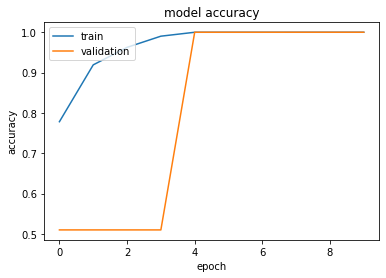

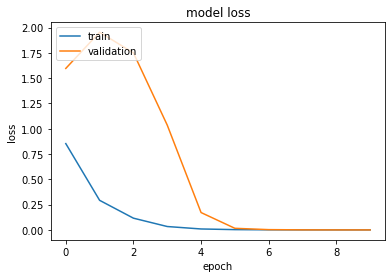

Epoch 1/10
1843/1843 - 3s - loss: 0.7336 - acc: 0.8100 - val_loss: 1.9117 - val_acc: 0.5101
Epoch 2/10
1843/1843 - 3s - loss: 0.2511 - acc: 0.9271 - val_loss: 2.2607 - val_acc: 0.5101
Epoch 3/10
1843/1843 - 3s - loss: 0.1136 - acc: 0.9617 - val_loss: 1.9512 - val_acc: 0.5101
Epoch 4/10
1843/1843 - 3s - loss: 0.0403 - acc: 0.9843 - val_loss: 1.5261 - val_acc: 0.5101
Epoch 5/10
1843/1843 - 3s - loss: 0.0122 - acc: 0.9999 - val_loss: 0.5965 - val_acc: 0.5101
Epoch 6/10
1843/1843 - 3s - loss: 0.0041 - acc: 0.9999 - val_loss: 0.0459 - val_acc: 0.9999
Epoch 7/10
1843/1843 - 3s - loss: 0.0016 - acc: 0.9999 - val_loss: 0.0028 - val_acc: 0.9999
Epoch 8/10
1843/1843 - 3s - loss: 8.0676e-04 - acc: 0.9999 - val_loss: 6.6454e-04 - val_acc: 1.0000
Epoch 9/10
1843/1843 - 3s - loss: 5.3479e-04 - acc: 0.9999 - val_loss: 3.1140e-04 - val_acc: 1.0000
Epoch 10/10
1843/1843 - 3s - loss: 4.1945e-04 - acc: 0.9999 - val_loss: 2.1470e-04 - val_acc: 1.0000
(110000, 12)
Test Score RMSE: 0.21289114995769207


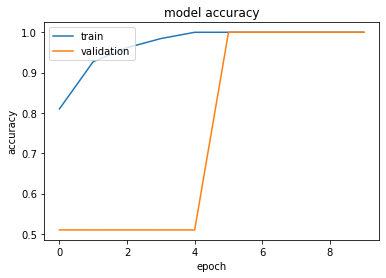

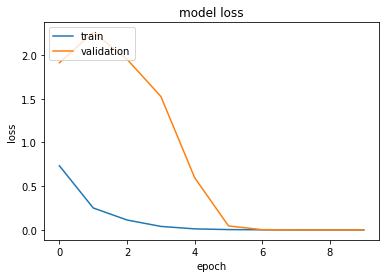

Epoch 1/10
1843/1843 - 2s - loss: 0.6606 - acc: 0.8262 - val_loss: 1.5847 - val_acc: 0.5101
Epoch 2/10
1843/1843 - 2s - loss: 0.2599 - acc: 0.9247 - val_loss: 2.1235 - val_acc: 0.5101
Epoch 3/10
1843/1843 - 2s - loss: 0.1357 - acc: 0.9567 - val_loss: 2.0190 - val_acc: 0.5101
Epoch 4/10
1843/1843 - 2s - loss: 0.0676 - acc: 0.9755 - val_loss: 1.4393 - val_acc: 0.5101
Epoch 5/10
1843/1843 - 2s - loss: 0.0285 - acc: 0.9914 - val_loss: 0.6702 - val_acc: 0.5101
Epoch 6/10
1843/1843 - 2s - loss: 0.0122 - acc: 0.9992 - val_loss: 0.2073 - val_acc: 0.9999
Epoch 7/10
1843/1843 - 2s - loss: 0.0049 - acc: 0.9999 - val_loss: 0.0484 - val_acc: 0.9999
Epoch 8/10
1843/1843 - 2s - loss: 0.0020 - acc: 0.9999 - val_loss: 0.0085 - val_acc: 0.9999
Epoch 9/10
1843/1843 - 2s - loss: 9.4202e-04 - acc: 0.9999 - val_loss: 0.0017 - val_acc: 0.9999
Epoch 10/10
1843/1843 - 2s - loss: 5.5196e-04 - acc: 0.9999 - val_loss: 5.0634e-04 - val_acc: 1.0000
(110000, 12)
Test Score RMSE: 0.23318683337328733


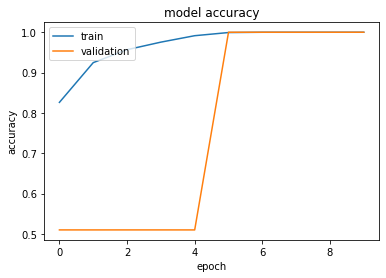

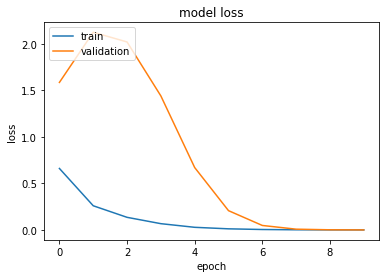

(276416, 1, 56) (276416, 12) (40000, 1, 56) (40000, 12) (110000, 1, 56) (110000, 12)
Epoch 1/10
1843/1843 - 3s - loss: 0.8548 - acc: 0.7739 - val_loss: 1.8828 - val_acc: 0.5101
Epoch 2/10
1843/1843 - 3s - loss: 0.2815 - acc: 0.9176 - val_loss: 2.0719 - val_acc: 0.5101
Epoch 3/10
1843/1843 - 3s - loss: 0.1295 - acc: 0.9600 - val_loss: 1.9501 - val_acc: 0.5101
Epoch 4/10
1843/1843 - 3s - loss: 0.0450 - acc: 0.9857 - val_loss: 1.4375 - val_acc: 0.5101
Epoch 5/10
1843/1843 - 3s - loss: 0.0122 - acc: 0.9999 - val_loss: 0.2152 - val_acc: 0.9997
Epoch 6/10
1843/1843 - 3s - loss: 0.0037 - acc: 0.9999 - val_loss: 0.0147 - val_acc: 0.9999
Epoch 7/10
1843/1843 - 3s - loss: 0.0014 - acc: 0.9999 - val_loss: 0.0024 - val_acc: 1.0000
Epoch 8/10
1843/1843 - 3s - loss: 7.3268e-04 - acc: 0.9999 - val_loss: 6.5618e-04 - val_acc: 1.0000
Epoch 9/10
1843/1843 - 3s - loss: 5.0476e-04 - acc: 0.9999 - val_loss: 2.7126e-04 - val_acc: 1.0000
Epoch 10/10
1843/1843 - 3s - loss: 3.8875e-04 - acc: 0.9999 - val_loss:

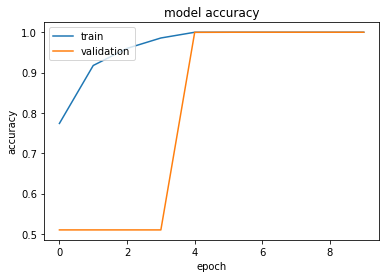

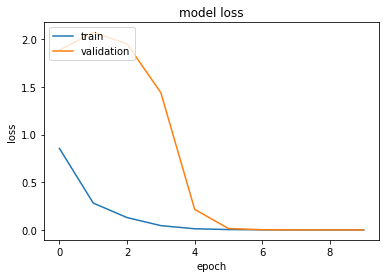

Epoch 1/10
1843/1843 - 3s - loss: 0.7717 - acc: 0.7882 - val_loss: 1.8302 - val_acc: 0.5101
Epoch 2/10
1843/1843 - 3s - loss: 0.3031 - acc: 0.9147 - val_loss: 2.3455 - val_acc: 0.5101
Epoch 3/10
1843/1843 - 3s - loss: 0.1245 - acc: 0.9602 - val_loss: 2.0457 - val_acc: 0.5101
Epoch 4/10
1843/1843 - 3s - loss: 0.0431 - acc: 0.9835 - val_loss: 1.4071 - val_acc: 0.5101
Epoch 5/10
1843/1843 - 3s - loss: 0.0143 - acc: 0.9996 - val_loss: 0.4386 - val_acc: 0.5541
Epoch 6/10
1843/1843 - 3s - loss: 0.0048 - acc: 0.9999 - val_loss: 0.0242 - val_acc: 0.9999
Epoch 7/10
1843/1843 - 3s - loss: 0.0019 - acc: 0.9999 - val_loss: 0.0026 - val_acc: 0.9999
Epoch 8/10
1843/1843 - 3s - loss: 8.7548e-04 - acc: 0.9999 - val_loss: 6.4534e-04 - val_acc: 1.0000
Epoch 9/10
1843/1843 - 3s - loss: 5.3981e-04 - acc: 0.9999 - val_loss: 2.7941e-04 - val_acc: 1.0000
Epoch 10/10
1843/1843 - 3s - loss: 4.0101e-04 - acc: 0.9999 - val_loss: 1.7041e-04 - val_acc: 1.0000
(110000, 12)
Test Score RMSE: 0.21487513226277008


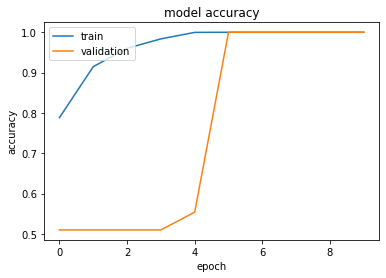

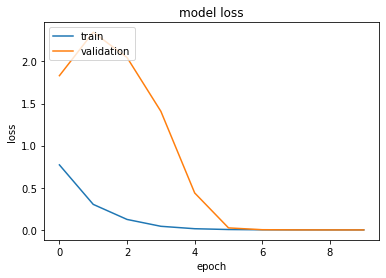

Epoch 1/10
1843/1843 - 2s - loss: 0.7347 - acc: 0.8050 - val_loss: 1.4715 - val_acc: 0.5101
Epoch 2/10
1843/1843 - 2s - loss: 0.2395 - acc: 0.9280 - val_loss: 2.3736 - val_acc: 0.5101
Epoch 3/10
1843/1843 - 2s - loss: 0.1156 - acc: 0.9625 - val_loss: 2.0742 - val_acc: 0.5101
Epoch 4/10
1843/1843 - 2s - loss: 0.0514 - acc: 0.9803 - val_loss: 1.5576 - val_acc: 0.5101
Epoch 5/10
1843/1843 - 2s - loss: 0.0206 - acc: 0.9972 - val_loss: 0.8119 - val_acc: 0.5101
Epoch 6/10
1843/1843 - 2s - loss: 0.0078 - acc: 0.9999 - val_loss: 0.1341 - val_acc: 0.9999
Epoch 7/10
1843/1843 - 2s - loss: 0.0030 - acc: 0.9999 - val_loss: 0.0210 - val_acc: 0.9999
Epoch 8/10
1843/1843 - 2s - loss: 0.0014 - acc: 0.9999 - val_loss: 0.0065 - val_acc: 0.9999
Epoch 9/10
1843/1843 - 2s - loss: 7.5602e-04 - acc: 0.9999 - val_loss: 0.0026 - val_acc: 0.9999
Epoch 10/10
1843/1843 - 2s - loss: 5.0668e-04 - acc: 0.9999 - val_loss: 0.0011 - val_acc: 1.0000
(110000, 12)
Test Score RMSE: 0.251948585765077


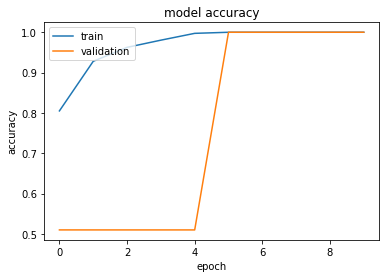

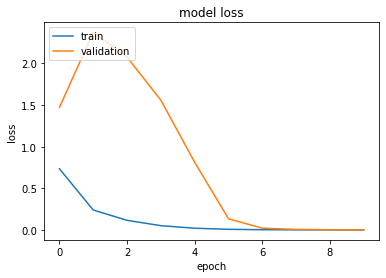

(276416, 1, 56) (276416, 12) (40000, 1, 56) (40000, 12) (110000, 1, 56) (110000, 12)
Epoch 1/10
1843/1843 - 3s - loss: 0.8740 - acc: 0.7702 - val_loss: 1.6102 - val_acc: 0.5101
Epoch 2/10
1843/1843 - 3s - loss: 0.2712 - acc: 0.9186 - val_loss: 2.1833 - val_acc: 0.5101
Epoch 3/10
1843/1843 - 3s - loss: 0.1213 - acc: 0.9616 - val_loss: 2.1681 - val_acc: 0.5101
Epoch 4/10
1843/1843 - 3s - loss: 0.0356 - acc: 0.9883 - val_loss: 1.4474 - val_acc: 0.5101
Epoch 5/10
1843/1843 - 3s - loss: 0.0096 - acc: 0.9999 - val_loss: 0.2024 - val_acc: 0.9999
Epoch 6/10
1843/1843 - 3s - loss: 0.0032 - acc: 0.9999 - val_loss: 0.0162 - val_acc: 0.9999
Epoch 7/10
1843/1843 - 3s - loss: 0.0013 - acc: 0.9999 - val_loss: 0.0033 - val_acc: 1.0000
Epoch 8/10
1843/1843 - 3s - loss: 7.4552e-04 - acc: 0.9999 - val_loss: 9.3016e-04 - val_acc: 1.0000
Epoch 9/10
1843/1843 - 3s - loss: 5.2801e-04 - acc: 0.9999 - val_loss: 3.9108e-04 - val_acc: 1.0000
Epoch 10/10
1843/1843 - 3s - loss: 4.1240e-04 - acc: 0.9999 - val_loss:

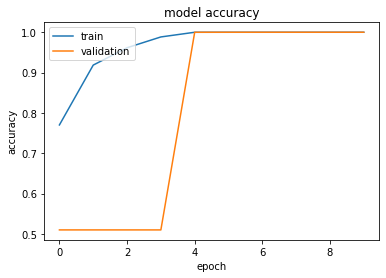

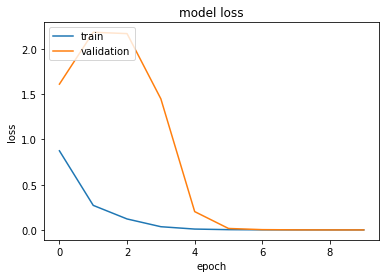

Epoch 1/10
1843/1843 - 3s - loss: 0.7717 - acc: 0.7951 - val_loss: 1.5505 - val_acc: 0.5101
Epoch 2/10
1843/1843 - 3s - loss: 0.2518 - acc: 0.9256 - val_loss: 2.3106 - val_acc: 0.5101
Epoch 3/10
1843/1843 - 3s - loss: 0.1254 - acc: 0.9595 - val_loss: 2.1107 - val_acc: 0.5101
Epoch 4/10
1843/1843 - 3s - loss: 0.0461 - acc: 0.9823 - val_loss: 1.4085 - val_acc: 0.5101
Epoch 5/10
1843/1843 - 3s - loss: 0.0145 - acc: 0.9993 - val_loss: 0.5113 - val_acc: 0.5105
Epoch 6/10
1843/1843 - 3s - loss: 0.0048 - acc: 0.9999 - val_loss: 0.0339 - val_acc: 0.9999
Epoch 7/10
1843/1843 - 3s - loss: 0.0019 - acc: 0.9999 - val_loss: 0.0057 - val_acc: 0.9999
Epoch 8/10
1843/1843 - 3s - loss: 8.7137e-04 - acc: 0.9999 - val_loss: 0.0015 - val_acc: 0.9999
Epoch 9/10
1843/1843 - 3s - loss: 5.3863e-04 - acc: 0.9999 - val_loss: 4.5718e-04 - val_acc: 1.0000
Epoch 10/10
1843/1843 - 3s - loss: 4.0354e-04 - acc: 0.9999 - val_loss: 2.3275e-04 - val_acc: 1.0000
(110000, 12)
Test Score RMSE: 0.2285680140246643


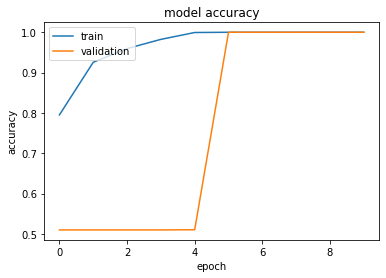

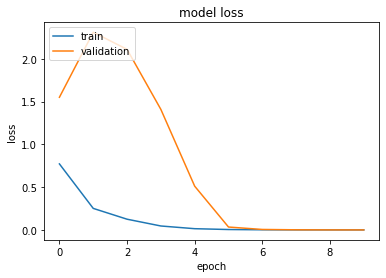

Epoch 1/10
1843/1843 - 2s - loss: 0.6453 - acc: 0.8328 - val_loss: 1.7315 - val_acc: 0.5101
Epoch 2/10
1843/1843 - 2s - loss: 0.2156 - acc: 0.9344 - val_loss: 2.0078 - val_acc: 0.5101
Epoch 3/10
1843/1843 - 2s - loss: 0.1139 - acc: 0.9619 - val_loss: 1.8547 - val_acc: 0.5101
Epoch 4/10
1843/1843 - 2s - loss: 0.0535 - acc: 0.9793 - val_loss: 1.2612 - val_acc: 0.5101
Epoch 5/10
1843/1843 - 2s - loss: 0.0200 - acc: 0.9961 - val_loss: 0.4430 - val_acc: 0.5637
Epoch 6/10
1843/1843 - 2s - loss: 0.0072 - acc: 0.9999 - val_loss: 0.0505 - val_acc: 0.9999
Epoch 7/10
1843/1843 - 2s - loss: 0.0027 - acc: 0.9999 - val_loss: 0.0088 - val_acc: 0.9999
Epoch 8/10
1843/1843 - 2s - loss: 0.0012 - acc: 0.9999 - val_loss: 0.0020 - val_acc: 0.9999
Epoch 9/10
1843/1843 - 2s - loss: 6.5085e-04 - acc: 0.9999 - val_loss: 6.2177e-04 - val_acc: 1.0000
Epoch 10/10
1843/1843 - 2s - loss: 4.5473e-04 - acc: 0.9999 - val_loss: 2.6944e-04 - val_acc: 1.0000
(110000, 12)
Test Score RMSE: 0.22547304540601795


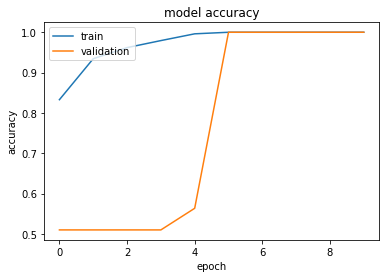

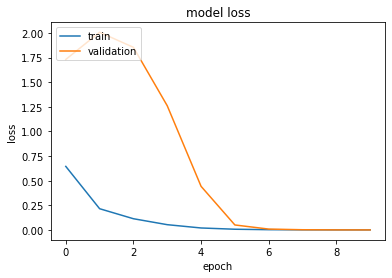

(276416, 1, 56) (276416, 12) (40000, 1, 56) (40000, 12) (110000, 1, 56) (110000, 12)
Epoch 1/10
1843/1843 - 4s - loss: 0.9507 - acc: 0.7448 - val_loss: 1.6499 - val_acc: 0.5101
Epoch 2/10
1843/1843 - 3s - loss: 0.2839 - acc: 0.9160 - val_loss: 2.1830 - val_acc: 0.5101
Epoch 3/10
1843/1843 - 3s - loss: 0.1191 - acc: 0.9622 - val_loss: 1.8149 - val_acc: 0.5101
Epoch 4/10
1843/1843 - 3s - loss: 0.0444 - acc: 0.9860 - val_loss: 0.4913 - val_acc: 0.5111
Epoch 5/10
1843/1843 - 3s - loss: 0.0121 - acc: 0.9998 - val_loss: 0.0099 - val_acc: 0.9999
Epoch 6/10
1843/1843 - 3s - loss: 0.0034 - acc: 0.9999 - val_loss: 0.0015 - val_acc: 0.9999
Epoch 7/10
1843/1843 - 3s - loss: 0.0014 - acc: 0.9999 - val_loss: 6.4108e-04 - val_acc: 1.0000
Epoch 8/10
1843/1843 - 3s - loss: 7.3220e-04 - acc: 0.9999 - val_loss: 3.6435e-04 - val_acc: 1.0000
Epoch 9/10
1843/1843 - 3s - loss: 5.1598e-04 - acc: 0.9999 - val_loss: 2.4614e-04 - val_acc: 1.0000
Epoch 10/10
1843/1843 - 3s - loss: 4.1215e-04 - acc: 0.9999 - val_l

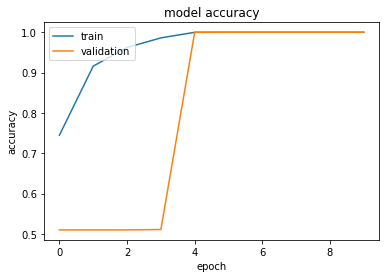

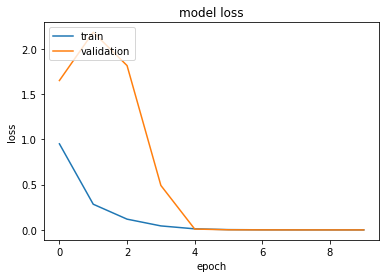

Epoch 1/10
1843/1843 - 3s - loss: 0.8216 - acc: 0.7904 - val_loss: 1.8314 - val_acc: 0.5101
Epoch 2/10
1843/1843 - 3s - loss: 0.2944 - acc: 0.9134 - val_loss: 2.0726 - val_acc: 0.5101
Epoch 3/10
1843/1843 - 3s - loss: 0.1295 - acc: 0.9559 - val_loss: 1.8491 - val_acc: 0.5101
Epoch 4/10
1843/1843 - 3s - loss: 0.0423 - acc: 0.9860 - val_loss: 1.1847 - val_acc: 0.5101
Epoch 5/10
1843/1843 - 3s - loss: 0.0117 - acc: 0.9999 - val_loss: 0.0987 - val_acc: 0.9999
Epoch 6/10
1843/1843 - 3s - loss: 0.0038 - acc: 0.9999 - val_loss: 0.0049 - val_acc: 0.9999
Epoch 7/10
1843/1843 - 3s - loss: 0.0015 - acc: 0.9999 - val_loss: 0.0014 - val_acc: 0.9999
Epoch 8/10
1843/1843 - 3s - loss: 7.3615e-04 - acc: 0.9999 - val_loss: 5.6971e-04 - val_acc: 1.0000
Epoch 9/10
1843/1843 - 3s - loss: 4.8664e-04 - acc: 0.9999 - val_loss: 2.9402e-04 - val_acc: 1.0000
Epoch 10/10
1843/1843 - 3s - loss: 3.6547e-04 - acc: 0.9999 - val_loss: 2.0876e-04 - val_acc: 1.0000
(110000, 12)
Test Score RMSE: 0.23810596741686774


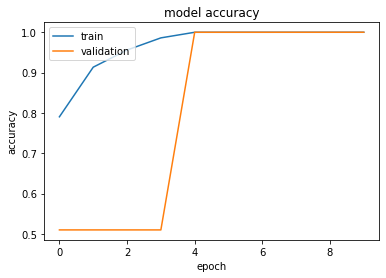

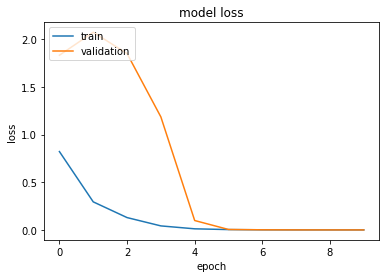

Epoch 1/10
1843/1843 - 2s - loss: 0.6566 - acc: 0.8267 - val_loss: 1.8936 - val_acc: 0.5101
Epoch 2/10
1843/1843 - 2s - loss: 0.2100 - acc: 0.9349 - val_loss: 2.2325 - val_acc: 0.5101
Epoch 3/10
1843/1843 - 2s - loss: 0.1012 - acc: 0.9685 - val_loss: 2.3017 - val_acc: 0.5101
Epoch 4/10
1843/1843 - 2s - loss: 0.0478 - acc: 0.9826 - val_loss: 2.0904 - val_acc: 0.5101
Epoch 5/10
1843/1843 - 2s - loss: 0.0199 - acc: 0.9979 - val_loss: 1.6421 - val_acc: 0.5101
Epoch 6/10
1843/1843 - 2s - loss: 0.0085 - acc: 0.9993 - val_loss: 0.8808 - val_acc: 0.5101
Epoch 7/10
1843/1843 - 2s - loss: 0.0037 - acc: 0.9999 - val_loss: 0.1814 - val_acc: 0.9999
Epoch 8/10
1843/1843 - 2s - loss: 0.0017 - acc: 0.9999 - val_loss: 0.0131 - val_acc: 1.0000
Epoch 9/10
1843/1843 - 2s - loss: 8.7036e-04 - acc: 0.9999 - val_loss: 0.0034 - val_acc: 1.0000
Epoch 10/10
1843/1843 - 2s - loss: 5.0715e-04 - acc: 0.9999 - val_loss: 9.5058e-04 - val_acc: 1.0000
(110000, 12)
Test Score RMSE: 0.2610924472011569


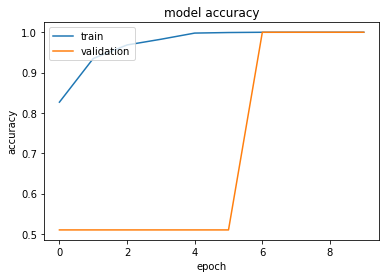

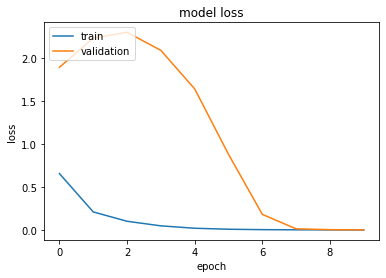

(276416, 1, 56) (276416, 12) (40000, 1, 56) (40000, 12) (110000, 1, 56) (110000, 12)
Epoch 1/10
1843/1843 - 4s - loss: 0.8672 - acc: 0.7690 - val_loss: 2.1021 - val_acc: 0.5101
Epoch 2/10
1843/1843 - 3s - loss: 0.2723 - acc: 0.9191 - val_loss: 2.2904 - val_acc: 0.5101
Epoch 3/10
1843/1843 - 3s - loss: 0.1131 - acc: 0.9644 - val_loss: 1.7418 - val_acc: 0.5101
Epoch 4/10
1843/1843 - 3s - loss: 0.0396 - acc: 0.9874 - val_loss: 0.7210 - val_acc: 0.5101
Epoch 5/10
1843/1843 - 3s - loss: 0.0135 - acc: 0.9993 - val_loss: 0.0615 - val_acc: 0.9999
Epoch 6/10
1843/1843 - 3s - loss: 0.0046 - acc: 0.9999 - val_loss: 0.0057 - val_acc: 1.0000
Epoch 7/10
1843/1843 - 3s - loss: 0.0018 - acc: 0.9999 - val_loss: 0.0012 - val_acc: 1.0000
Epoch 8/10
1843/1843 - 3s - loss: 8.7064e-04 - acc: 0.9999 - val_loss: 4.7485e-04 - val_acc: 1.0000
Epoch 9/10
1843/1843 - 3s - loss: 5.6862e-04 - acc: 0.9999 - val_loss: 2.6505e-04 - val_acc: 1.0000
Epoch 10/10
1843/1843 - 3s - loss: 4.4542e-04 - acc: 0.9999 - val_loss:

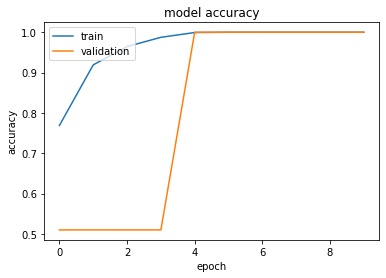

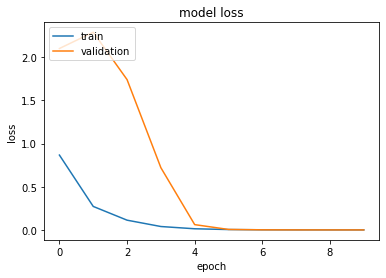

Epoch 1/10
1843/1843 - 3s - loss: 0.7566 - acc: 0.8020 - val_loss: 1.6590 - val_acc: 0.5101
Epoch 2/10
1843/1843 - 3s - loss: 0.2804 - acc: 0.9160 - val_loss: 2.1385 - val_acc: 0.5101
Epoch 3/10
1843/1843 - 3s - loss: 0.1301 - acc: 0.9609 - val_loss: 1.8454 - val_acc: 0.5101
Epoch 4/10
1843/1843 - 3s - loss: 0.0459 - acc: 0.9822 - val_loss: 0.8759 - val_acc: 0.5101
Epoch 5/10
1843/1843 - 3s - loss: 0.0130 - acc: 0.9992 - val_loss: 0.0566 - val_acc: 0.9999
Epoch 6/10
1843/1843 - 3s - loss: 0.0039 - acc: 0.9999 - val_loss: 0.0053 - val_acc: 0.9999
Epoch 7/10
1843/1843 - 3s - loss: 0.0015 - acc: 0.9999 - val_loss: 0.0011 - val_acc: 0.9999
Epoch 8/10
1843/1843 - 3s - loss: 7.4815e-04 - acc: 0.9999 - val_loss: 4.1495e-04 - val_acc: 1.0000
Epoch 9/10
1843/1843 - 3s - loss: 4.8987e-04 - acc: 0.9999 - val_loss: 2.0096e-04 - val_acc: 1.0000
Epoch 10/10
1843/1843 - 3s - loss: 3.7362e-04 - acc: 0.9999 - val_loss: 1.2287e-04 - val_acc: 1.0000
(110000, 12)
Test Score RMSE: 0.23234600944677464


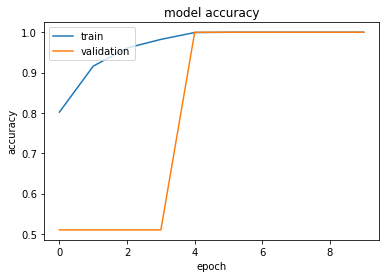

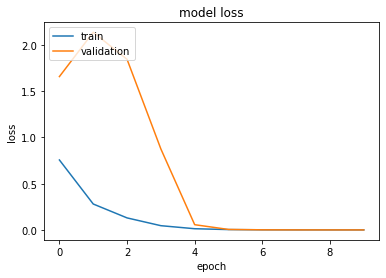

Epoch 1/10
1843/1843 - 2s - loss: 0.6672 - acc: 0.8240 - val_loss: 1.8017 - val_acc: 0.5101
Epoch 2/10
1843/1843 - 2s - loss: 0.2325 - acc: 0.9299 - val_loss: 2.3464 - val_acc: 0.5101
Epoch 3/10
1843/1843 - 2s - loss: 0.1188 - acc: 0.9592 - val_loss: 2.1251 - val_acc: 0.5101
Epoch 4/10
1843/1843 - 2s - loss: 0.0487 - acc: 0.9820 - val_loss: 1.7697 - val_acc: 0.5101
Epoch 5/10
1843/1843 - 2s - loss: 0.0191 - acc: 0.9975 - val_loss: 1.1420 - val_acc: 0.5101
Epoch 6/10
1843/1843 - 2s - loss: 0.0076 - acc: 0.9999 - val_loss: 0.2611 - val_acc: 0.9481
Epoch 7/10
1843/1843 - 2s - loss: 0.0030 - acc: 0.9999 - val_loss: 0.0314 - val_acc: 0.9999
Epoch 8/10
1843/1843 - 2s - loss: 0.0013 - acc: 0.9999 - val_loss: 0.0040 - val_acc: 0.9999
Epoch 9/10
1843/1843 - 2s - loss: 7.1698e-04 - acc: 0.9999 - val_loss: 8.1527e-04 - val_acc: 1.0000
Epoch 10/10
1843/1843 - 2s - loss: 4.6903e-04 - acc: 0.9999 - val_loss: 2.6098e-04 - val_acc: 1.0000
(110000, 12)
Test Score RMSE: 0.2366411720916882


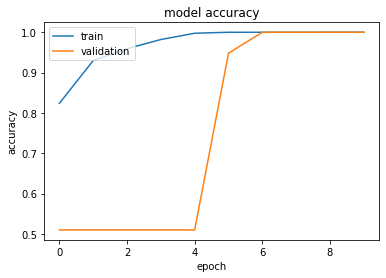

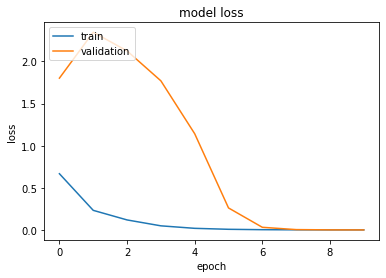

(276416, 1, 56) (276416, 12) (40000, 1, 56) (40000, 12) (110000, 1, 56) (110000, 12)
Epoch 1/10
1843/1843 - 4s - loss: 0.9123 - acc: 0.7603 - val_loss: 1.6957 - val_acc: 0.5101
Epoch 2/10
1843/1843 - 3s - loss: 0.3031 - acc: 0.9175 - val_loss: 1.9907 - val_acc: 0.5101
Epoch 3/10
1843/1843 - 3s - loss: 0.1136 - acc: 0.9639 - val_loss: 1.6032 - val_acc: 0.5101
Epoch 4/10
1843/1843 - 3s - loss: 0.0364 - acc: 0.9881 - val_loss: 0.4091 - val_acc: 0.5424
Epoch 5/10
1843/1843 - 3s - loss: 0.0092 - acc: 0.9999 - val_loss: 0.0209 - val_acc: 0.9999
Epoch 6/10
1843/1843 - 3s - loss: 0.0029 - acc: 0.9999 - val_loss: 0.0030 - val_acc: 0.9999
Epoch 7/10
1843/1843 - 3s - loss: 0.0012 - acc: 0.9999 - val_loss: 8.6244e-04 - val_acc: 0.9999
Epoch 8/10
1843/1843 - 3s - loss: 6.8265e-04 - acc: 0.9999 - val_loss: 4.0099e-04 - val_acc: 1.0000
Epoch 9/10
1843/1843 - 3s - loss: 5.0759e-04 - acc: 0.9999 - val_loss: 2.7536e-04 - val_acc: 1.0000
Epoch 10/10
1843/1843 - 3s - loss: 4.1370e-04 - acc: 0.9999 - val_l

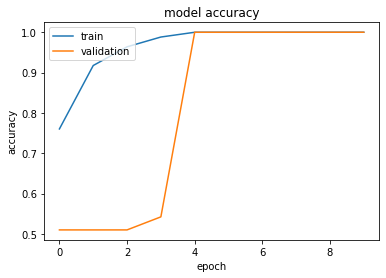

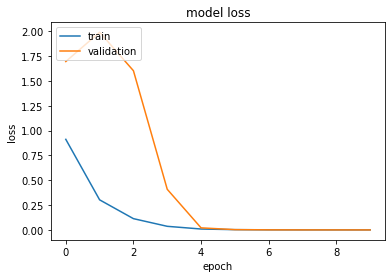

Epoch 1/10
1843/1843 - 3s - loss: 0.7631 - acc: 0.8005 - val_loss: 1.7758 - val_acc: 0.5101
Epoch 2/10
1843/1843 - 3s - loss: 0.2471 - acc: 0.9237 - val_loss: 2.1564 - val_acc: 0.5101
Epoch 3/10
1843/1843 - 3s - loss: 0.1126 - acc: 0.9638 - val_loss: 2.1269 - val_acc: 0.5101
Epoch 4/10
1843/1843 - 3s - loss: 0.0405 - acc: 0.9849 - val_loss: 1.4535 - val_acc: 0.5101
Epoch 5/10
1843/1843 - 3s - loss: 0.0127 - acc: 0.9993 - val_loss: 0.5563 - val_acc: 0.5119
Epoch 6/10
1843/1843 - 3s - loss: 0.0043 - acc: 0.9999 - val_loss: 0.0317 - val_acc: 0.9999
Epoch 7/10
1843/1843 - 3s - loss: 0.0017 - acc: 0.9999 - val_loss: 0.0024 - val_acc: 0.9999
Epoch 8/10
1843/1843 - 3s - loss: 8.0429e-04 - acc: 0.9999 - val_loss: 6.5193e-04 - val_acc: 0.9999
Epoch 9/10
1843/1843 - 3s - loss: 5.0729e-04 - acc: 0.9999 - val_loss: 2.7780e-04 - val_acc: 1.0000
Epoch 10/10
1843/1843 - 3s - loss: 3.7984e-04 - acc: 0.9999 - val_loss: 1.6219e-04 - val_acc: 1.0000
(110000, 12)
Test Score RMSE: 0.2271325733158756


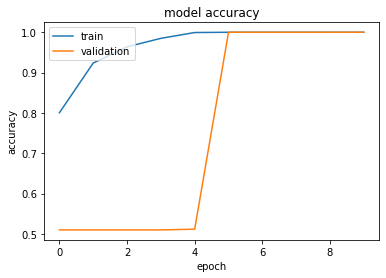

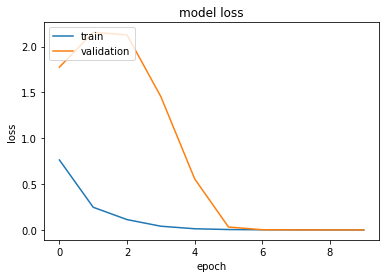

Epoch 1/10
1843/1843 - 2s - loss: 0.6295 - acc: 0.8328 - val_loss: 1.4856 - val_acc: 0.5101
Epoch 2/10
1843/1843 - 2s - loss: 0.2232 - acc: 0.9345 - val_loss: 2.0647 - val_acc: 0.5101
Epoch 3/10
1843/1843 - 2s - loss: 0.1071 - acc: 0.9659 - val_loss: 1.9004 - val_acc: 0.5101
Epoch 4/10
1843/1843 - 2s - loss: 0.0513 - acc: 0.9810 - val_loss: 1.2187 - val_acc: 0.5101
Epoch 5/10
1843/1843 - 2s - loss: 0.0229 - acc: 0.9947 - val_loss: 0.2485 - val_acc: 0.9867
Epoch 6/10
1843/1843 - 2s - loss: 0.0089 - acc: 0.9999 - val_loss: 0.0340 - val_acc: 0.9999
Epoch 7/10
1843/1843 - 2s - loss: 0.0035 - acc: 0.9999 - val_loss: 0.0055 - val_acc: 0.9999
Epoch 8/10
1843/1843 - 2s - loss: 0.0016 - acc: 0.9999 - val_loss: 0.0013 - val_acc: 0.9999
Epoch 9/10
1843/1843 - 2s - loss: 8.2980e-04 - acc: 0.9999 - val_loss: 4.5364e-04 - val_acc: 0.9999
Epoch 10/10
1843/1843 - 2s - loss: 5.2658e-04 - acc: 0.9999 - val_loss: 2.2962e-04 - val_acc: 1.0000
(110000, 12)
Test Score RMSE: 0.23997906555078496


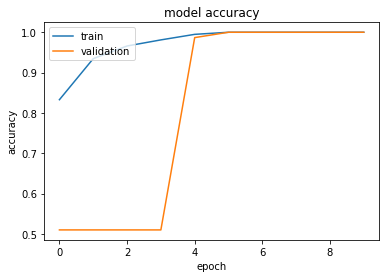

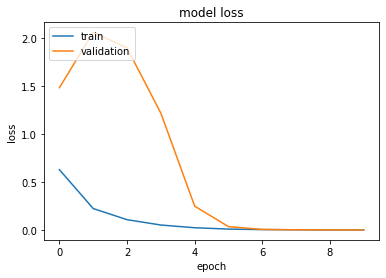

(276416, 1, 56) (276416, 12) (40000, 1, 56) (40000, 12) (110000, 1, 56) (110000, 12)
Epoch 1/10
1843/1843 - 4s - loss: 0.8455 - acc: 0.7796 - val_loss: 1.9487 - val_acc: 0.5101
Epoch 2/10
1843/1843 - 3s - loss: 0.3201 - acc: 0.9115 - val_loss: 2.2141 - val_acc: 0.5101
Epoch 3/10
1843/1843 - 3s - loss: 0.1197 - acc: 0.9613 - val_loss: 1.8954 - val_acc: 0.5101
Epoch 4/10
1843/1843 - 3s - loss: 0.0381 - acc: 0.9886 - val_loss: 1.1287 - val_acc: 0.5101
Epoch 5/10
1843/1843 - 3s - loss: 0.0104 - acc: 0.9999 - val_loss: 0.2140 - val_acc: 0.9996
Epoch 6/10
1843/1843 - 3s - loss: 0.0033 - acc: 0.9999 - val_loss: 0.0176 - val_acc: 0.9999
Epoch 7/10
1843/1843 - 3s - loss: 0.0013 - acc: 0.9999 - val_loss: 0.0043 - val_acc: 1.0000
Epoch 8/10
1843/1843 - 3s - loss: 6.9910e-04 - acc: 0.9999 - val_loss: 0.0012 - val_acc: 1.0000
Epoch 9/10
1843/1843 - 3s - loss: 4.8982e-04 - acc: 0.9999 - val_loss: 4.2488e-04 - val_acc: 1.0000
Epoch 10/10
1843/1843 - 3s - loss: 3.8817e-04 - acc: 0.9999 - val_loss: 2.5

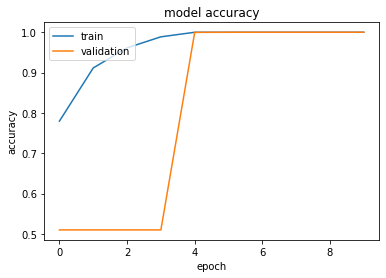

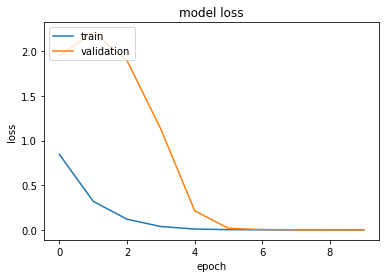

Epoch 1/10
1843/1843 - 3s - loss: 0.6776 - acc: 0.8204 - val_loss: 1.8307 - val_acc: 0.5101
Epoch 2/10
1843/1843 - 3s - loss: 0.2477 - acc: 0.9263 - val_loss: 2.5190 - val_acc: 0.5101
Epoch 3/10
1843/1843 - 3s - loss: 0.1177 - acc: 0.9613 - val_loss: 1.9456 - val_acc: 0.5101
Epoch 4/10
1843/1843 - 3s - loss: 0.0470 - acc: 0.9818 - val_loss: 1.4314 - val_acc: 0.5101
Epoch 5/10
1843/1843 - 3s - loss: 0.0158 - acc: 0.9985 - val_loss: 0.3830 - val_acc: 0.5663
Epoch 6/10
1843/1843 - 3s - loss: 0.0054 - acc: 0.9999 - val_loss: 0.0136 - val_acc: 0.9999
Epoch 7/10
1843/1843 - 3s - loss: 0.0021 - acc: 0.9999 - val_loss: 0.0019 - val_acc: 0.9999
Epoch 8/10
1843/1843 - 3s - loss: 9.7429e-04 - acc: 0.9999 - val_loss: 5.8309e-04 - val_acc: 0.9999
Epoch 9/10
1843/1843 - 3s - loss: 5.7365e-04 - acc: 0.9999 - val_loss: 2.5933e-04 - val_acc: 1.0000
Epoch 10/10
1843/1843 - 3s - loss: 4.0265e-04 - acc: 0.9999 - val_loss: 1.5541e-04 - val_acc: 1.0000
(110000, 12)
Test Score RMSE: 0.21879400083243244


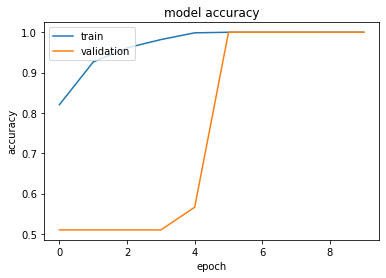

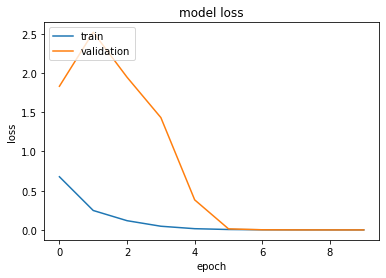

Epoch 1/10
1843/1843 - 2s - loss: 0.6182 - acc: 0.8454 - val_loss: 1.3402 - val_acc: 0.5101
Epoch 2/10
1843/1843 - 2s - loss: 0.2250 - acc: 0.9336 - val_loss: 2.1133 - val_acc: 0.5101
Epoch 3/10
1843/1843 - 2s - loss: 0.1123 - acc: 0.9631 - val_loss: 1.7109 - val_acc: 0.5101
Epoch 4/10
1843/1843 - 2s - loss: 0.0511 - acc: 0.9818 - val_loss: 0.7149 - val_acc: 0.5101
Epoch 5/10
1843/1843 - 2s - loss: 0.0210 - acc: 0.9967 - val_loss: 0.0582 - val_acc: 0.9999
Epoch 6/10
1843/1843 - 2s - loss: 0.0077 - acc: 0.9999 - val_loss: 0.0068 - val_acc: 0.9999
Epoch 7/10
1843/1843 - 2s - loss: 0.0029 - acc: 0.9999 - val_loss: 0.0016 - val_acc: 0.9999
Epoch 8/10
1843/1843 - 2s - loss: 0.0013 - acc: 0.9999 - val_loss: 5.6719e-04 - val_acc: 0.9999
Epoch 9/10
1843/1843 - 2s - loss: 6.6982e-04 - acc: 0.9999 - val_loss: 2.7277e-04 - val_acc: 0.9999
Epoch 10/10
1843/1843 - 2s - loss: 4.3627e-04 - acc: 0.9999 - val_loss: 1.7401e-04 - val_acc: 1.0000
(110000, 12)
Test Score RMSE: 0.24174510635809712


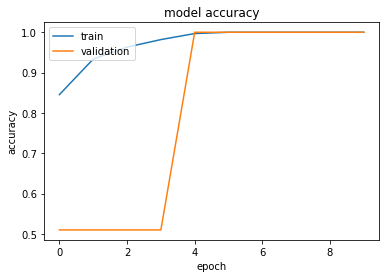

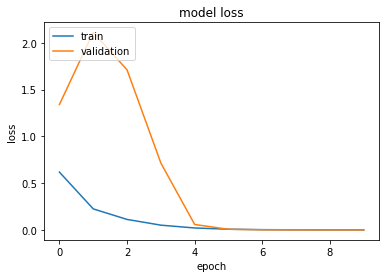

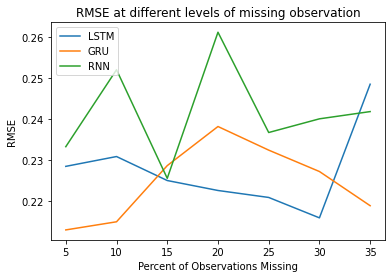

In [40]:
lst = range(5,40, 5)
test_acc_lstm = list()
test_acc_gru = list()
test_acc_simple = list()

for i in lst:
    dataset = copy.copy()
    dataset = noise(i/100, 0.1, dataset)
    #dataset.loc[:,:] = dataset.loc[:,:].ffill()
    train_X, train_y, val_X, val_y, test_X, test_y  = preprocess(dataset)
    print(train_X.shape, train_y.shape, val_X.shape, val_y.shape, test_X.shape, test_y.shape)
    
    accuracy_lstm = lstm(train_X, train_y, val_X, val_y, test_X, test_y)
    test_acc_lstm.append(accuracy_lstm)
    
    accuracy_gru = gru(train_X, train_y, val_X, val_y, test_X, test_y)
    test_acc_gru.append(accuracy_gru)
    
    accuracy_simple = simpleRNN(train_X, train_y, val_X, val_y, test_X, test_y)
    test_acc_simple.append(accuracy_simple)
    
pyplot.plot(lst,test_acc_lstm)
pyplot.plot(lst,test_acc_gru)
pyplot.plot(lst,test_acc_simple)
pyplot.title('RMSE at different levels of missing observation')
pyplot.ylabel('RMSE')
pyplot.xlabel('Percent of Observations Missing')
pyplot.legend(['LSTM', 'GRU', 'RNN'], loc='upper left')
pyplot.show()

## 2-Layer LSTM

In [371]:
def lstm2(train_X, train_y, val_X, val_y, test_X, test_y):   
    # design network
    model = Sequential()
    model.add(LSTM(30, return_sequences=True, input_shape=(train_X.shape[1], train_X.shape[2])))
    model.add(LSTM(30))
    model.add(Dense(12, activation='softmax'))
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['acc'])

    #es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=3)


    # fit network
    history = model.fit(train_X, train_y, epochs=10, batch_size=150, validation_data=(val_X, val_y), verbose=2, shuffle=False)


    testPredict = model.predict(test_X)
    #testPredict = scaler.inverse_transform(testPredict)
    #testY = scaler.inverse_transform([test_y])
    
    print(testPredict.shape)
    
    testScore = math.sqrt(mean_squared_error(test_y, testPredict)) #/test_y.shape[0]
    print('Test Score RMSE: ' + str(testScore))
    
    pyplot.plot(history.history['acc'])
    pyplot.plot(history.history['val_acc'])
    pyplot.title('model accuracy')
    pyplot.ylabel('accuracy')
    pyplot.xlabel('epoch')
    pyplot.legend(['train', 'validation'], loc='upper left')
    pyplot.show()

    # plot history
    pyplot.plot(history.history['loss'], label='train')
    pyplot.plot(history.history['val_loss'], label='test')
    pyplot.title('model loss')
    pyplot.ylabel('loss')
    pyplot.xlabel('epoch')
    pyplot.legend(['train', 'validation'], loc='upper left')
    pyplot.show()
    return testScore

# NAIVE

In [525]:
def naive(dataset): 
    one_hot = pd.get_dummies(dataset['activityID'])
    dataset = dataset.drop('activityID',axis = 1)
    dataset = dataset.join(one_hot)  
    
    
    # load dataset
    values = dataset.values

    # ensure all data is float
    values = values.astype('float32')

    # normalize features
    scaler = MinMaxScaler(feature_range=(0, 1))
    scaled = scaler.fit_transform(values)

    # frame as supervised learning
    reframed = series_to_supervised(scaled, 1, 1)
    
    reframed.drop(reframed.columns[[*range(0, 41)]], axis=1, inplace=True)
    reframed.drop(reframed.columns[[*range(13, 54)]], axis=1, inplace=True)
    
    y_pred = reframed.iloc[: , :13]
    y_target = reframed.iloc[: , 13:]
    
    testScore = math.sqrt(mean_squared_error(y_target, y_pred)) #/test_y.shape[0]
    print('Test Score RMSE: ' + str(testScore))
    
    return testScore


Test Score RMSE: 0.003196533648568739
Test Score RMSE: 0.00327957047183927
Test Score RMSE: 0.0033694394664119235
Test Score RMSE: 0.0034671253093684425
Test Score RMSE: 0.003573831992846502
Test Score RMSE: 0.0036910393302881602
Test Score RMSE: 0.003820590235847462
Test Score RMSE: 0.003964807350994027
Test Score RMSE: 0.004126703816148683
Test Score RMSE: 0.004310203001534409
Test Score RMSE: 0.004520581238387863
Test Score RMSE: 0.004765113862149263
Test Score RMSE: 0.005054170311502944
Test Score RMSE: 0.005403140964091993
Test Score RMSE: 0.005836040504694275
Test Score RMSE: 0.006393067297137478
Test Score RMSE: 0.007147676201070915
Test Score RMSE: 0.008253443776593428


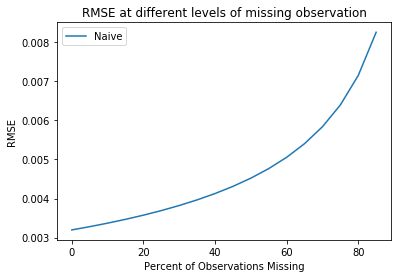

In [527]:
lst = range(0,90, 5)
test_acc_naive = list()

for i in lst:
    dataset = copy.copy()
    dataset = drop(i/100, dataset)
    #train_X, train_y, val_X, val_y, test_X, test_y  = preprocess(dataset)
    #print(train_X.shape, train_y.shape, val_X.shape, val_y.shape, test_X.shape, test_y.shape)
    
    accuracy = naive(dataset)
    test_acc_naive.append(accuracy)
    
pyplot.plot(lst,test_acc_naive)
pyplot.title('RMSE at different levels of missing observation')
pyplot.ylabel('RMSE')
pyplot.xlabel('Percent of Observations Missing')
pyplot.legend(['Naive'], loc='upper left')
pyplot.show()

## Add more accuracy metrics